# **PDS Projekt -- Statistická analýza dat**


#### **Autor: Vojtěch Fiala \<xfiala61\>**

Tento Jupyter Notebook obsahuje analýzu datového souboru ``tls-pds-07-03-2024.parquet``. Soubor obsahuje zachycenou HTTPS komunikaci na portu 443 v nespecifikované síti. Komunikace je zachycena v podobě TCP toků s jejich vlastnostmi, kdy jeden tok odpovídá jednomu záznamu (řádku). Cílem analýzy bude odhalit statistické vlastnosti a zjistit informace o poskynutých datech. Na konci tohoto Notebooku budou zodpovězeny otázky ze zadání (odpovědi na ně vychází z informací, které Notebook uvádí).

Uváděná čísla budou zaokrouhlena na 2 desetinná místa.


Analýza bude založena na knihovnách pandas a matplotlib.
Začátkem analýzy je import potřebných knihoven a poskytnutá data jsou načtena do DataFrame objektu.

In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy
import seaborn

# Cesta k datovemu souboru
INPUT_FILE_PATH = "./tls-pds-07-03-2024.parquet"

# Nacteni souboru
df = pandas.read_parquet(INPUT_FILE_PATH)

Z názvů jednotlivých sloupců budou odstraněny datové typy, které se ve sloupci vyskytují. Buňka níže tyto typy odstraní a provede výpis všech sloupců, které se v datové sadě vyskytují. Také je získán celkový počet řádků.

In [2]:
# Odstraneni datovych typu z nazvu sloupcu (nebudu je potrebovat)
for col in df.columns.tolist():
    col_names = col.split()
    if len(col_names) > 1:
        df = df.rename(columns={col:col_names[1]})

# Vypis sloupcu a poctu zaznamu
print(df.columns.tolist())
print("Celkovy pocet vsech zaznamu:", df.shape[0])

['TLS_SNI', 'TIME_FIRST', 'TIME_LAST', 'PACKETS', 'PACKETS_REV', 'BYTES', 'BYTES_REV', 'TCP_FLAGS', 'PPI_PKT_DIRECTIONS', 'PPI_PKT_TIMES', 'PPI_PKT_LENGTHS', 'PPI_PKT_FLAGS']
Celkovy pocet vsech zaznamu: 1287422


Dataset jako takový obsahuje **1 287 422** řádků/toků. Popis informací obsažených v jednotlivých sloupcích je v [zadání](https://moodle.vut.cz/pluginfile.php/843353/mod_page/content/10/PDS_analyza_podobnosti_sluzeb_07_03_2024.pdf). Detailnější informace jsou, jak zadání zmiňuje, na stránkách [ipfixprobe](https://github.com/CESNET/ipfixprobe).

Analýza bude rozdělena na dvě části:
- *Jednotlivé sloupce* -- Jednotlivé sloupce a vlastnosti, které z nich bude možné vyčíst. 
- *Kombinace sloupců* -- Informace, které lze získat z vícero sloupců zároveň. 

# Jednotlivé sloupce

Tato sekce se zaměří na analýzu jednotlivých sloupců. Pokud spolu sloupce přímo souvisí (např. TIME_FIRST, TIME_LAST), budou analyzovány společně. 

## TLS_SNI

První analyzovaný sloupec bude TLS_SNI. Tento sloupec popisuje název serveru, kam se klient přes HTTPS protokol napojil. Ve většině případů je názvem serveru jeho adresa, takže v rámci analýzy bude hodnota tohoto sloupce označován jako adresa.

### Základní statistiky pro jednotlivé adresy
V následující buňce budou získány základní statistické informace o tocích. Dále bude zjištěno 10 služeb, ke kterým toky směřovaly nejčastěji:

count    19910.000000
mean        64.662079
std        960.405222
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      75182.000000
Name: count, dtype: float64
TLS_SNI
www.google.com                 75182
dns.google                     31026
doh.opendns.com                28923
fonts.gstatic.com              28832
play.googleapis.com            23845
www.youtube.com                22728
googleads.g.doubleclick.net    22438
safebrowsing.googleapis.com    22146
mail.google.com                21146
www.googleapis.com             21052
Name: count, dtype: int64


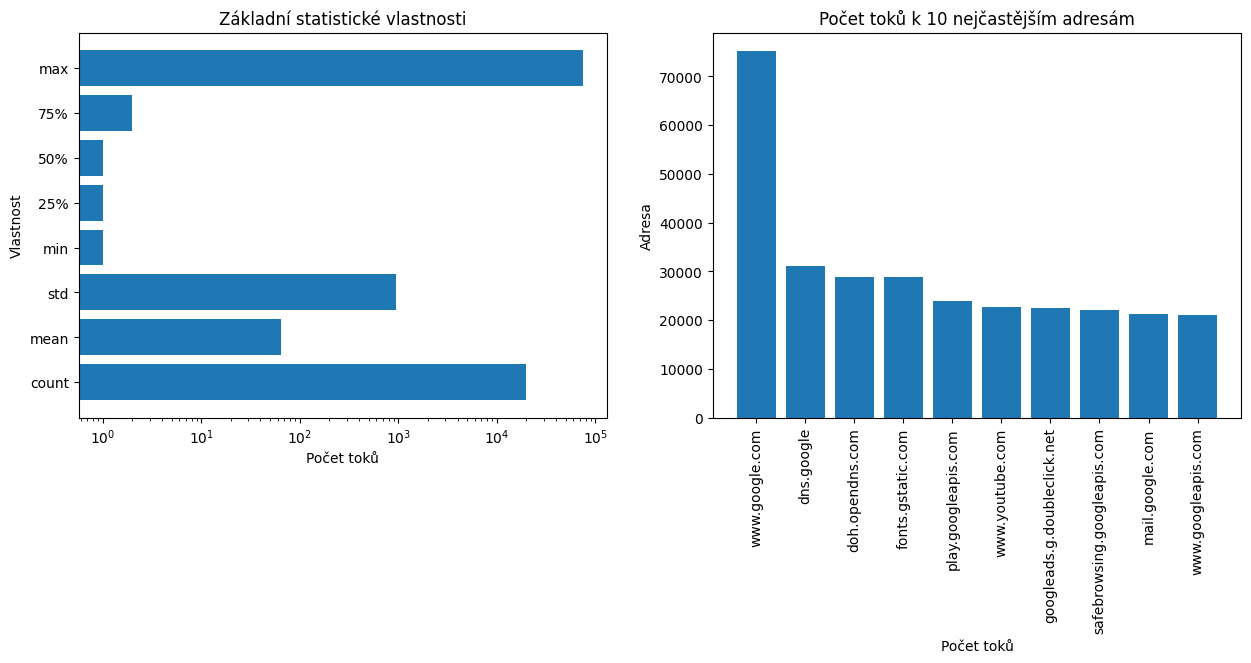

In [3]:
# Serazeni adres od nejcasteji navstevovane
value_counts = df['TLS_SNI'].value_counts()

n_of_plotted = 10

# Statisticky popis
print(value_counts.describe())
print(value_counts.nlargest(n_of_plotted))

# Ziskani pozadovanych N hodnot
n_largest = value_counts.nlargest(n_of_plotted)

# Tvorba obrazku ktery bude obsahovat 2 obrazky
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Tvorba grafu vlevo
ax[0].barh(value_counts.describe().index, value_counts.describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[0].set_title("Základní statistické vlastnosti")
ax[0].set_xlabel('Počet toků')
ax[0].set_ylabel('Vlastnost')

# Tvorba grafu vpravo
ax[1].bar(n_largest.index, n_largest.values)

# Nastaveni popisu obrazku a os X a Y
ax[1].set_title("Počet toků k " + str(n_of_plotted) + " nejčastějším adresám")
ax[1].set_xlabel('Počet toků')
ax[1].set_ylabel('Adresa')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()

<a id="most_common_addresses"></a>
#### Výsledky základní statistiky pro jednotlivé adresy
- Je patrné, že celkem bylo vytvořeno spojení s celkem **19 910** adresami
- **75%** hodnota je **1** -- více než 75% všech adres má tedy zaznamenaný pouze 1 tok k nim
- Průměrný počet spojení s jednou adresou je **64.66**
- Vzhledem k směrodatné odchylce **960.41** se počty velmi liší napříč jednotlivými adresami, což lze vidět i ve vizualizaci statistických vlastností.

#### Nejčastější adresy
- Je patrné, že maximální počet toků byl na adresu ``www.google.com`` a to celkem **75 182**. 
- To bylo víc než **2x** častěji než na druhou nejčastější adresu, ``dns.google.com``.

Zajímavostí je, že v TOP 5 výsledcích souvisí 2 z nich s DNS -- to by mohlo znamenat, že uživatelé sítě aktivně používají [DNS over HTTPS](https://en.wikipedia.org/wiki/DNS_over_HTTPS). Mezi stránkami s nejvíce toky se dále pohybují Youtube (6. nejčastější) a níže i Spotify (není zachyceno na grafu) , což naznačuje, že uživatelé v síti poměrně často poslouchají hudbu.

### Četnost toků k jednotlivým adresám
Minimálně 3/4 všech unikátních adres mají zaznamenán pouze jeden tok k nim. Jelikož je vidět velký rozestup mezi minimálním a maximálním počtem toků k jedné adrese, zaměříme se na to, jak jednotlivé toky vypadají. Konkrétně srovnáme počet toků k adresám, které se vyskytly méně než 5x (tedy 1x, 2x, 3x, 4x), s ostatními adresami, tzn. těmi, které se vyskytly aspoň 5x.
V souvislosti s tím se zaměříme i na počet unikátních adres, ke kterými se aspoň 5x vytvořil tok a tyto výsledky srovnám.

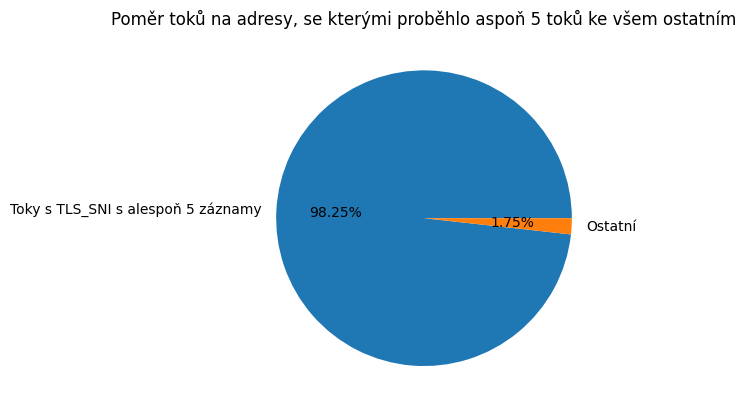

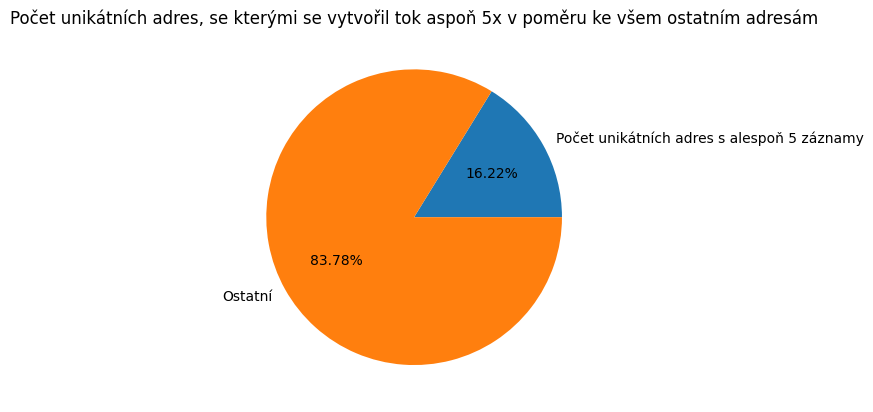

In [4]:
# Pruzkum jednotlivych hodnot - zakomentovane, neni potreba spamovat vystup
# print(df["TLS_SNI"].value_counts().head(300).to_string())

# Konstanta
cutoff_occurences = 5

# Pocty toku k adresam
val_counts = df["TLS_SNI"].value_counts()

# Odfiltruj pocet vyskytu tam, kde je < 5 (tzn. nech jen ty, kde je > 4)
val_counts = val_counts[val_counts >= cutoff_occurences]

# Podle indexu vyfiltrovanych radku vyber jenom je (tzn. jejich indexy) -> pocet toku k adresam, ktere se objevily alespon 5x
n_of_occurs = df[df["TLS_SNI"].isin(val_counts.index)]["TLS_SNI"].value_counts().sum(numeric_only=True)

# Pocet_vsech_radku - pocet_alespon_5 = pocet_<_5.
less_than_cutoff = df.shape[0] - n_of_occurs

# Tvorba obrazku
fig, ax = plt.subplots()

# Piechart pro pocet toku k adresam v TLS_SNI, ktere maji aspon 5 zaznamu v pomeru ke vsem ostatnim
ax.pie([n_of_occurs, less_than_cutoff], labels=["Toky s TLS_SNI s alespoň " + str(cutoff_occurences) + " záznamy", "Ostatní"], autopct='%1.2f%%');
ax.set_title("Poměr toků na adresy, se kterými proběhlo aspoň " + str(cutoff_occurences) + " toků ke všem ostatním")

# Pocet unikatnich adres, ktere zaznamenaly aspon 5 toku, vuci tem, ktere ne.
n_of_occurs_unique_over_n = df[df["TLS_SNI"].isin(val_counts.index)]["TLS_SNI"].nunique()
n_of_uniques = df["TLS_SNI"].nunique()

# Dalsi obrazek
fig, ax = plt.subplots()

n_of_occurs_unique_under_n = n_of_uniques - n_of_occurs_unique_over_n

# Pocet toku k adresam TLS_SNI, ktere maji aspon 30 zaznamu v pomeru k ostatnim
ax.pie([n_of_occurs_unique_over_n, n_of_occurs_unique_under_n], labels=["Počet unikátních adres s alespoň " + str(cutoff_occurences) + " záznamy", "Ostatní"], autopct='%1.2f%%');
ax.set_title("Počet unikátních adres, se kterými se vytvořil tok aspoň " + str(cutoff_occurences) + "x v poměru ke všem ostatním adresám");


#### Unikátnost adres
- **83.78%** všech unikátních adres serveru (tzn. sloupec TLS_SNI) se vyskytlo pouze **1-4x**. V kontextu všech toků se ale jedná o pouhých **1.75%**. 
- **1.75 %** všech záznamů obsahuje **83.78%** všech unikátních adres. To znamená, že ve velké většině případů (**98.25%**) se spojení vytvářela se servery opakovaně (tzn. aspoň 5x), nebo bylo využíváno více toků pro jednu komunikaci zároveň - uživatelé, jejichž toky byly měřeny, se pravděpodobně pohybují na již znamých stránkách a nové stránky tvoří jen malé procento navštívených.


Je nutné zmínit, že mnoho z nejčastějších adres pravděpodobně nejsou stránky, které by uživatel navštěvoval vědomě, ale automaticky v rámci fungování aplikací (dns.google, doh.opendns.com, font.gstatic.com, play.googleapis.com....)


### Četnost domén prvního a druhého řádu
Podle národních domén, se kterými se toky spojovali, je možné odhadnout, odkud uživatelé v síti jsou. Podle domén druhého řádu je možné určit, které služby byly nejvíce využívané.

TLS_SNI_DOMAIN_TOP
.com       1040333
.net         87052
.sk          38923
.google      31052
.cz          29465
            ...   
.sg              1
.za              1
.cx              1
.pk              1
.guru            1
Name: count, Length: 160, dtype: int64
TLS_SNI_DOMAIN_SECOND_TOP
.google         263907
.googleapis     243106
.gstatic        107899
.doubleclick     53812
.spotify         47550
                 ...  
.m2b                 1
.bajerov             1
.vip-pradlo          1
.ddns                1
.jemezdravo          1
Name: count, Length: 4411, dtype: int64


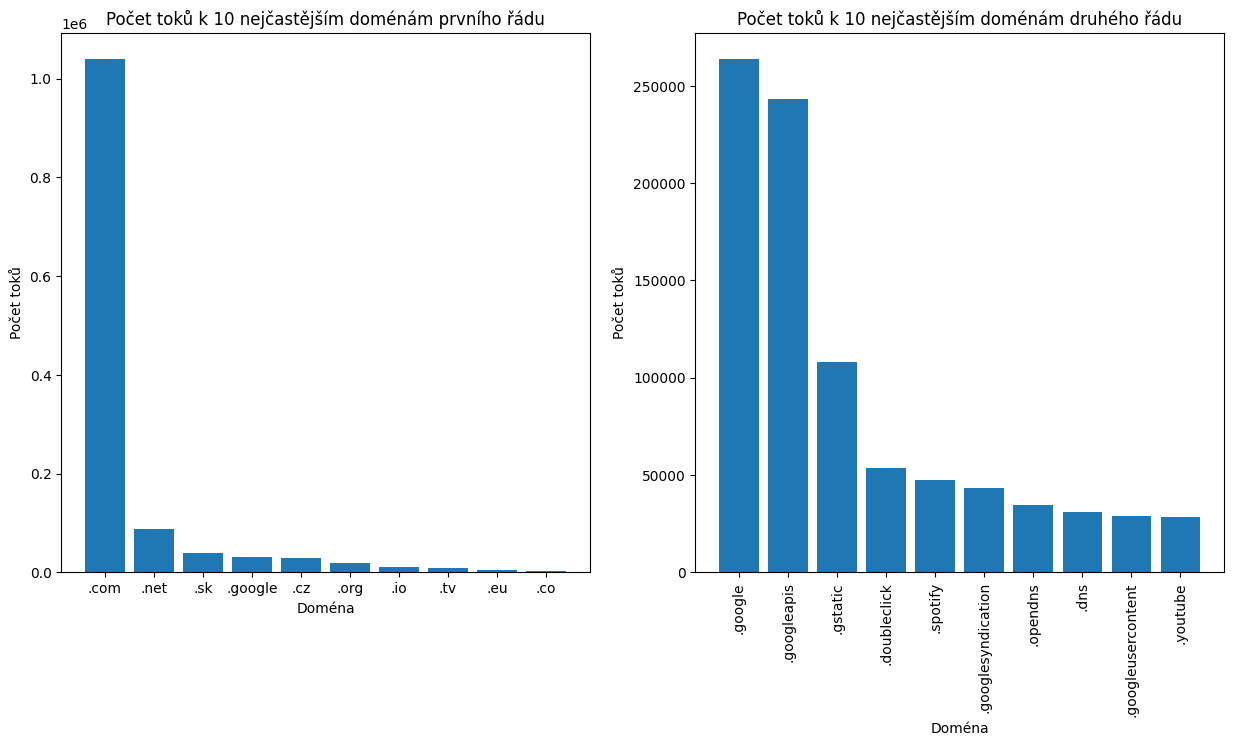

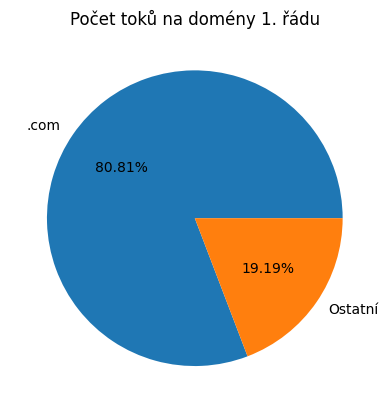

In [5]:
# Umely sloupec obsahujici domenu prvniho radu (.cz, .com...)
df["TLS_SNI_DOMAIN_TOP"] = '.' + df["TLS_SNI"].str.split('.').str[-1]

# Umely sloupec obsahujici domenu druheho radu (.google...)
df["TLS_SNI_DOMAIN_SECOND_TOP"] = '.' + df["TLS_SNI"].str.split('.').str[-2]

n_of_plotted = 10
most_visited_domains = df["TLS_SNI_DOMAIN_TOP"]
most_visited_domains_second = df["TLS_SNI_DOMAIN_SECOND_TOP"]

# Vypis vsech nalezenych domen prvniho raddu
print(most_visited_domains.value_counts())

# Vypis vsech nalezenych domen druheho raddu
print(most_visited_domains_second.value_counts())

# Ziskani pozadovanych N hodnot
n_largest = most_visited_domains.value_counts().nlargest(n_of_plotted)
n_largest_second = most_visited_domains_second.value_counts().nlargest(n_of_plotted)

# Tvorba obrazku ktery bude obsahovat 2 obrazky
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Tvorba grafu vpravo
ax[0].bar(n_largest.index, n_largest.values)

# Nastaveni popisu obrazku a os X a Y
ax[0].set_title("Počet toků k " + str(n_of_plotted) + " nejčastějším doménám prvního řádu")
ax[0].set_xlabel('Doména')
ax[0].set_ylabel('Počet toků')

# Tvorba grafu vlevo
ax[1].bar(n_largest_second.index, n_largest_second.values)

# Nastaveni popisu obrazku a os X a Y
ax[1].set_title("Počet toků k " + str(n_of_plotted) + " nejčastějším doménám druhého řádu")
ax[1].set_xlabel('Doména')
ax[1].set_ylabel('Počet toků')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()

# Pomer .com ku vsem ostatnim
sum_of_first_level_most_visited = most_visited_domains.value_counts().nlargest(1).sum()
sum_of_rest = df.shape[0] - sum_of_first_level_most_visited

# Tvorba obrazku
fig, ax = plt.subplots()

# Kolac
ax.pie([sum_of_first_level_most_visited, sum_of_rest], labels=[".com", "Ostatní"], autopct='%1.2f%%');

# Nastaveni popisu obrazku
ax.set_title("Počet toků na domény 1. řádu");
plt.show()

#### Počty domén prvního a druhého řádu:
- Zdaleka nejčastější doména prvního řádu je ``.com``, která má více než **1 000 000** záznamů a vedlo k ní **80.81%** všech toků.
- Dále jsou často zastoupeny domény ``.net``, ``.sk``, ``.google`` a ``.cz``.
- Celkem bylo nalezeno 160 různých domén prvního řádu
- Podle domén prvního řádu by se dalo odhadnout, že uživatelé navštěvují stránky primárně v angličtině (.com), ale jsou mezi nimi i češi a slováci (.cz, .sk)
- Nejčastější domény druhého řádu jsou spojené s googlem. Vyskytuje se zde ale i .spotify, což potvrzuje, že Spotify je také relativně používaná služba.
- Bylo nalezeno celkem 4411 domén druhého řádu

### Adresy bez domény prvního řádu
Zde se zaměříme na to, jestli existují adresy, které neobsahují validní doménu prvního řádu. Kontrola proběhne tak, že se ověří, že za poslední tečkou v adrese následuje písmeno.

In [6]:
invalid_tld = df[~df["TLS_SNI_DOMAIN_TOP"].str[1].str.isalpha()]["TLS_SNI_DOMAIN_TOP"]
print(invalid_tld.value_counts())
print("Pocet neplatnych adres:", invalid_tld.value_counts().sum())
print("Podil neplatnych adres v procentech:", (invalid_tld.value_counts().sum() / df.shape[0]) * 100)

TLS_SNI_DOMAIN_TOP
.99       21
.8        12
.4         1
.?4180     1
Name: count, dtype: int64
Pocet neplatnych adres: 35
Podil neplatnych adres v procentech: 0.0027186113022769536


#### Netextové adresy
- Byly nalezeny čtyři adresy, které neodpovídají URL formátu -- konkrétně byly např. ve formátu ``8.8.4.4``
- Těchto adres bylo nalezeno celkem 35, což je 0.0027% všech adres
- Lze je označit za anomálie

### Výskyt pornografických webů
Při úvodním manuálním prohlížení datasetu byla objevena stránka s pornografickým obsahem. Tato sekce se zaměří na to, kolik takových webů bylo zaznamenáno napříč komunikací.

In [7]:
print("Zajimavost - Frekvence vyskytu pornografickych webu:\n")
# Zajimavost - kolik je v datasetu navstivenych 18+ webu? Pri prohlizeni dat jsem na jeden nahodou narazil... kolik jich je celkem?
# https://www.semrush.com/trending-websites/global/adult - weby jako patreon nebo deviantart nejsou vyhradne nsfw, takze je nezahrnuju
# Seznam nize obsahuje vybrane stranky z https://www.semrush.com/trending-websites/global/adult a nejcastejsi nazvy podobnych stranek
top_10_most_visited_p_sites_regex = '|'.join(["xvideos.com", "xnxx.com", "xhamster.com", "onlyfans.com", 
"redtube.com", "thisvid.com", "redgifs.com", "porn", "hentai"])

# Vypis vsech vysledku
print(df[df["TLS_SNI"].str.contains(top_10_most_visited_p_sites_regex)]["TLS_SNI"].value_counts().to_string())

# Jeden z nich - podporneopatrenia.minedu.sk - nevypada jako hledana stranka - odstranim jeji vysledky (-2)
p_results = df[df["TLS_SNI"].str.contains(top_10_most_visited_p_sites_regex)]["TLS_SNI"].value_counts().sum(numeric_only=True) - 2
print("Pornografickych webu:", p_results, ".\nTyto weby tvori pouze minimalne", (p_results / df.shape[0]) * 100 ,"% vsech vysledku")

Zajimavost - Frekvence vyskytu pornografickych webu:

TLS_SNI
www.pornuj.cz                             10
jenporno-cz.webpkgcache.com                3
podporneopatrenia.minedu.sk                2
hentaihaven-xxx.webpkgcache.com            2
pornjack.net                               1
www.lifeisporno.com                        1
amp-xhamster-com.cdn.ampproject.org        1
thepornguy-org.webpkgcache.com             1
cz-amp-xhamster-com.cdn.ampproject.org     1
media.porndudecdn.com                      1
Pornografickych webu: 21 .
Tyto weby tvori pouze minimalne 0.0016311667813661722 % vsech vysledku


#### Nalezené pornografické weby
- Při běžném provozu bylo dle [článku](https://www.statista.com/chart/16959/share-of-the-internet-that-is-porn/) v letech 2005-2014 tohoto typu provozu něco mezi 13-20%
- Očekávány byly podobné hodnoty, nicméně dataset takových webů obsahuje pouze 0.0016 % -- celkem 21 výskytů. To může znamenat, že se pravděpodobně nejedná o data z "domácí" sítě, ale spíše z nějaké pracovní sítě a tyto stránky jsou navštěvovány pouze za vznešenými účely. Konkrétní nalezené stránky jsou vypsány v seznamu výše. Je však možné, že nebyly nalezeny všechny.

<a id="google_adresy"></a>
### Google adresy

Stránkou, se kterou se spojení ustanovuje nejčastěji ze všech je www.google.com, viz sekce [základní statistiky](#most_common_addresses). Vzhledem k tomu, že se mezi adresami s vysokým počtem výskytů objevuje i google.cz a google.sk (a také google.cn), to utvrzuje dominantní postavení google vyhledávače. 

Buňka níže získá všechny adresy obsahující slovo "google" a zobrazí, kolik toků souvisí se službami od Googlu.


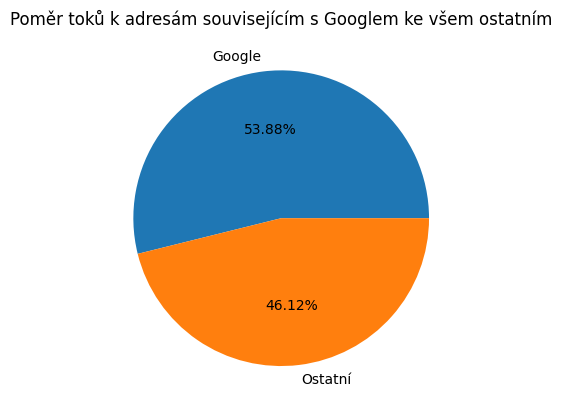

In [8]:
# Hledej "google" substring v cele adrese a spocitej, kolik jich je
googles = df[df["TLS_SNI"].str.contains("google")]["TLS_SNI"].value_counts().sum(numeric_only=True)

# Pocet vsech ostatnich:
other_pages = df["TLS_SNI"].value_counts().sum(numeric_only=True) - googles

# Vytvor obrazek
fig, ax = plt.subplots()
ax.set_title("Poměr toků k adresám souvisejícím s Googlem ke všem ostatním")
ax.pie([googles, other_pages], labels=["Google", "Ostatní"], autopct='%1.2f%%');


#### Přítomnost Googlu
- Výsledky obsahující substring "google" tvoří nadpoloviční většinu (**53.88%**) všech toků.
- Součásti jsou i služby, které běží pravděpodobně někde na pozadí (dns.google...)



Jelikož je počet toků souvisejících s Googlem tak vysoký, je možné, že data pochází od uživatelů používajících pravděpodobně Google Chrome nebo přímo ChromeOS. Toto jsou ovšem pouze spekulace, co je jisté, tak je fakt, že služby Googlu tvoří nadpoloviční většinu veškerého HTTPS trafficu.

## TIME_FIRST, TIME_LAST

Tato sekce se zaměří na čas začátku a konce toku. Jelikož se jedná o první a poslední timestamp daného toku, jsou tyto dvě hodnoty analyzovány společně.

### Rozložení toků v čase

Nejprve si graficky zobrazíme rozložení toků v čase, tzn. v jaký čas bylo toků nejvíce a v jaký nejméně. 

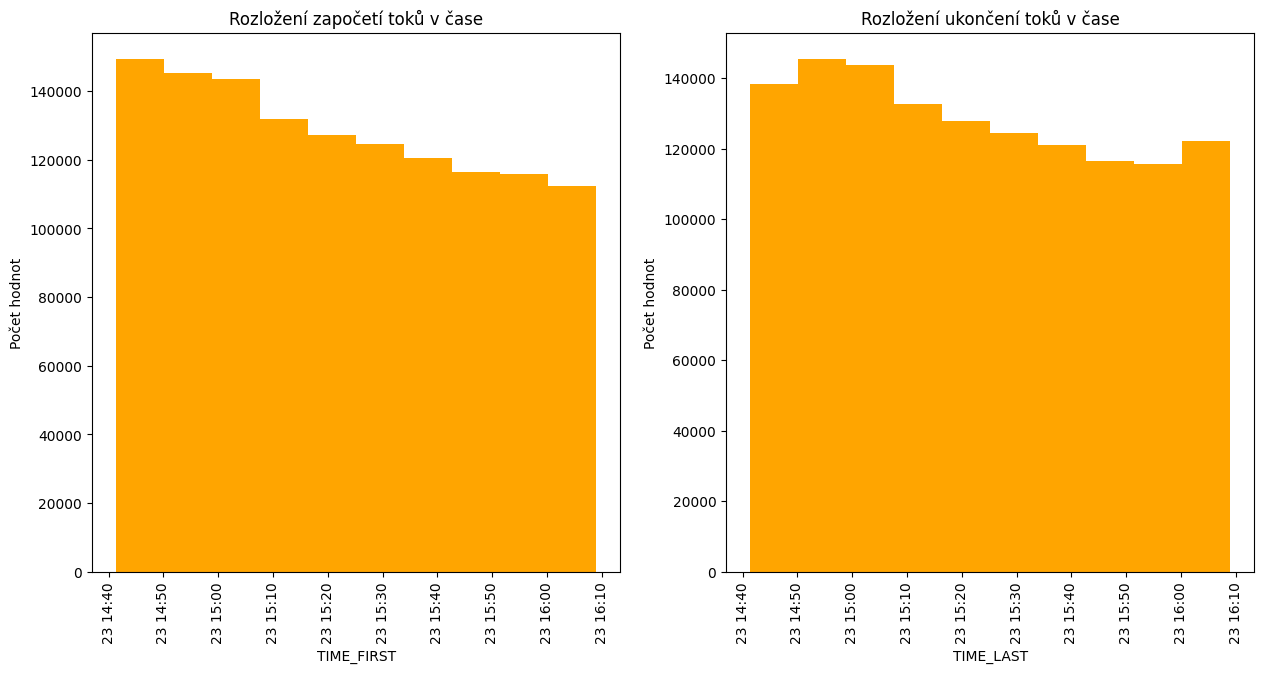

In [9]:
# Tvorba obrazku ktery bude obsahovat 2 obrazky
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Tvorba grafu vpravo
ax[0].hist(df["TIME_FIRST"], bins=10, color='orange')

# Nastaveni popisu obrazku a os X a Y
ax[0].set_title("Rozložení započetí toků v čase")
ax[0].set_xlabel('TIME_FIRST')
ax[0].set_ylabel('Počet hodnot')

# Otoceni osy X, at jsou casy citelne
ax[0].tick_params(axis='x', rotation=90)

# Tvorba grafu vlevo
ax[1].hist(df["TIME_LAST"], bins=10, color='orange')

# Nastaveni popisu obrazku a os X a Y
ax[1].set_title("Rozložení ukončení toků v čase")
ax[1].set_xlabel('TIME_LAST')
ax[1].set_ylabel('Počet hodnot')

# Otoceni osy X, at jsou casy citelne
ax[1].tick_params(axis='x', rotation=90)

# Zobrazeni obrazku
plt.show()

#### Aktivita toků
- Dataset vznikl mezi 14:40 a 16:10 23.11.2023 a obsahuje tedy komunikaci trvající cca 1h 30m.
- Také je možné pozorovat klesající trend počtu vzniklých toků s tím, jak plynul čas.

Na konci sběru dat je vidět skok v množství ukončených toků -- je možné, že všechny tou dobou otevřené byly ukončeny.

### Jak dlouho byla data sbírána
Buňka níže popisuje čas získání prvního otevřeného toku a čas zavření posledního toku. Z toho posléze spočítá dobu, po jakou byly toky měřeny.

In [10]:
print(df["TIME_FIRST"].min())
print(df["TIME_LAST"].max())

print(df["TIME_LAST"].max() - df["TIME_FIRST"].min())

2023-11-23 14:41:20.993908
2023-11-23 16:09:01.156837
0 days 01:27:40.162929


#### Čas datasetu
- Data pochází z 23.11.2023 z období mezi 14:41 a 16:09
- Nejstarší započatá komunikace a nejnovější ukončená mají mezi sebou rozdil 1h 27m 40s - to je doba sběru dat.

### Statistické informace o celkové době toku
Ze sloupců TIME_FIRST a TIME_LAST vypočteme dobu trvání každého toku a zjistíme o ní základní statistické informace.

count                   1287422
mean     0 days 00:00:40.666770
std      0 days 00:01:48.723443
min      0 days 00:00:00.011905
25%      0 days 00:00:00.271899
50%      0 days 00:00:04.106949
75%      0 days 00:00:32.607066
max      0 days 01:19:04.599242
Name: TIMES, dtype: object
1% nejdelsich toku ma delku vetsi nez: 290.0


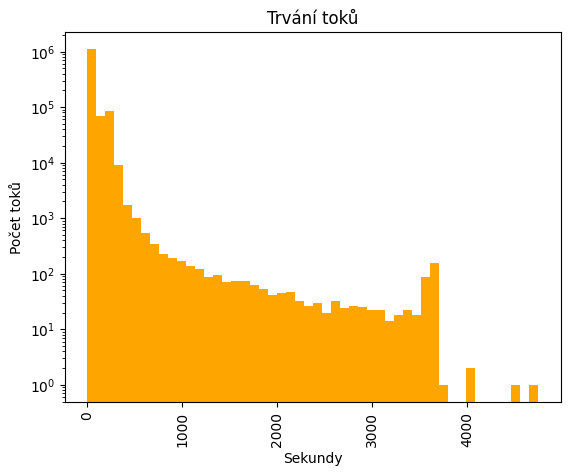

In [11]:
df["TIMES"] = df["TIME_LAST"] - df["TIME_FIRST"]
times = df["TIMES"]
print(times.describe())

# Obrazek prumerne delky toku
fig, ax = plt.subplots()

# Casy v sekundach
times_numeric = df["TIMES"].astype("int64") // 1e6

print("1% nejdelsich toku ma delku vetsi nez:", times_numeric.quantile(0.99))

# Tvorba grafu, logaritmicke skalovani 
ax.hist(times_numeric, bins=50, color='orange', log=True)

# Nastaveni popisu obrazku a os X a Y
ax.set_title("Trvání toků")
ax.set_xlabel('Sekundy')
ax.set_ylabel('Počet toků')

# Otoceni osy X, at jsou casy citelne
ax.tick_params(axis='x', rotation=90)

# Zobrazeni obrazku
plt.show()

#### Základní statistiky doby toku
- Průměrná doba trvání jednoho toku byla **40.66** vteřin.
- Nejkratší tok je v řádu setin sekundy (**0.011** sekundy)
- Nejdelší tok trval **1h 19m 4.6s** -- skoro celou dobu odchytávání komunikace.
- Z grafu vyplývá, že většina toků trvala velmi krátkou dobu.
- Kvantil **0.99** má hranici **290**, tzn. 99% toků trvalo dobu kratší nebo stejnou než 290 sekund. 

V kontextu s informacemi z dalších sloupců, čemuž se bude věnovat druhá hlavní sekce tohoto Notebooku, budou tyto hodnoty zajímavější. K analýze více sloupců naráz se dostaneme později.

## PACKETS, PACKETS_REV, BYTES, BYTES_REV

Tyto sloupce obsahují hodnoty týkající se počtu paketů a bytů zaslaných v toku, kde PACKETS a BYTES je směrem od zdroje k cíli (klient->server) a PACKETS_REV a BYTES_REV naopak.

Pakety a byty poslané klientem na server budu uvažovat jako upload. Pakety a byty poslané opačným směrem, tedy ze serveru na klienta, jako download. 

### Základní statistické informace o uploadu/downloadu
Jako první si zjistím základí informace jak o uploadu, tak downloadu:

UPLOAD PACKETS:
 count    1.287422e+06
mean     6.769930e+01
std      5.730877e+03
min      1.000000e+00
25%      1.000000e+01
50%      1.500000e+01
75%      2.000000e+01
max      4.154231e+06
Name: PACKETS, dtype: float64
DOWNLOAD PACKETS:
 count    1.287422e+06
mean     1.254380e+02
std      8.349892e+03
min      1.000000e+00
25%      9.000000e+00
50%      1.500000e+01
75%      2.200000e+01
max      5.999166e+06
Name: PACKETS_REV, dtype: float64
TOTAL PACKETS:
 count    1.287422e+06
mean     1.931373e+02
std      1.226382e+04
min      3.000000e+00
25%      1.900000e+01
50%      3.000000e+01
75%      4.300000e+01
max      6.518895e+06
Name: TOTAL_PACKETS, dtype: float64
UPLOAD BYTES:
 count    1.287422e+06
mean     3.615192e+04
std      7.425772e+06
min      2.630000e+02
25%      1.273000e+03
50%      2.189000e+03
75%      3.554000e+03
max      5.102440e+09
Name: BYTES, dtype: float64
DOWNLOAD BYTES:
 count    1.287422e+06
mean     1.408180e+05
std      1.155789e+07
min      5.200000e

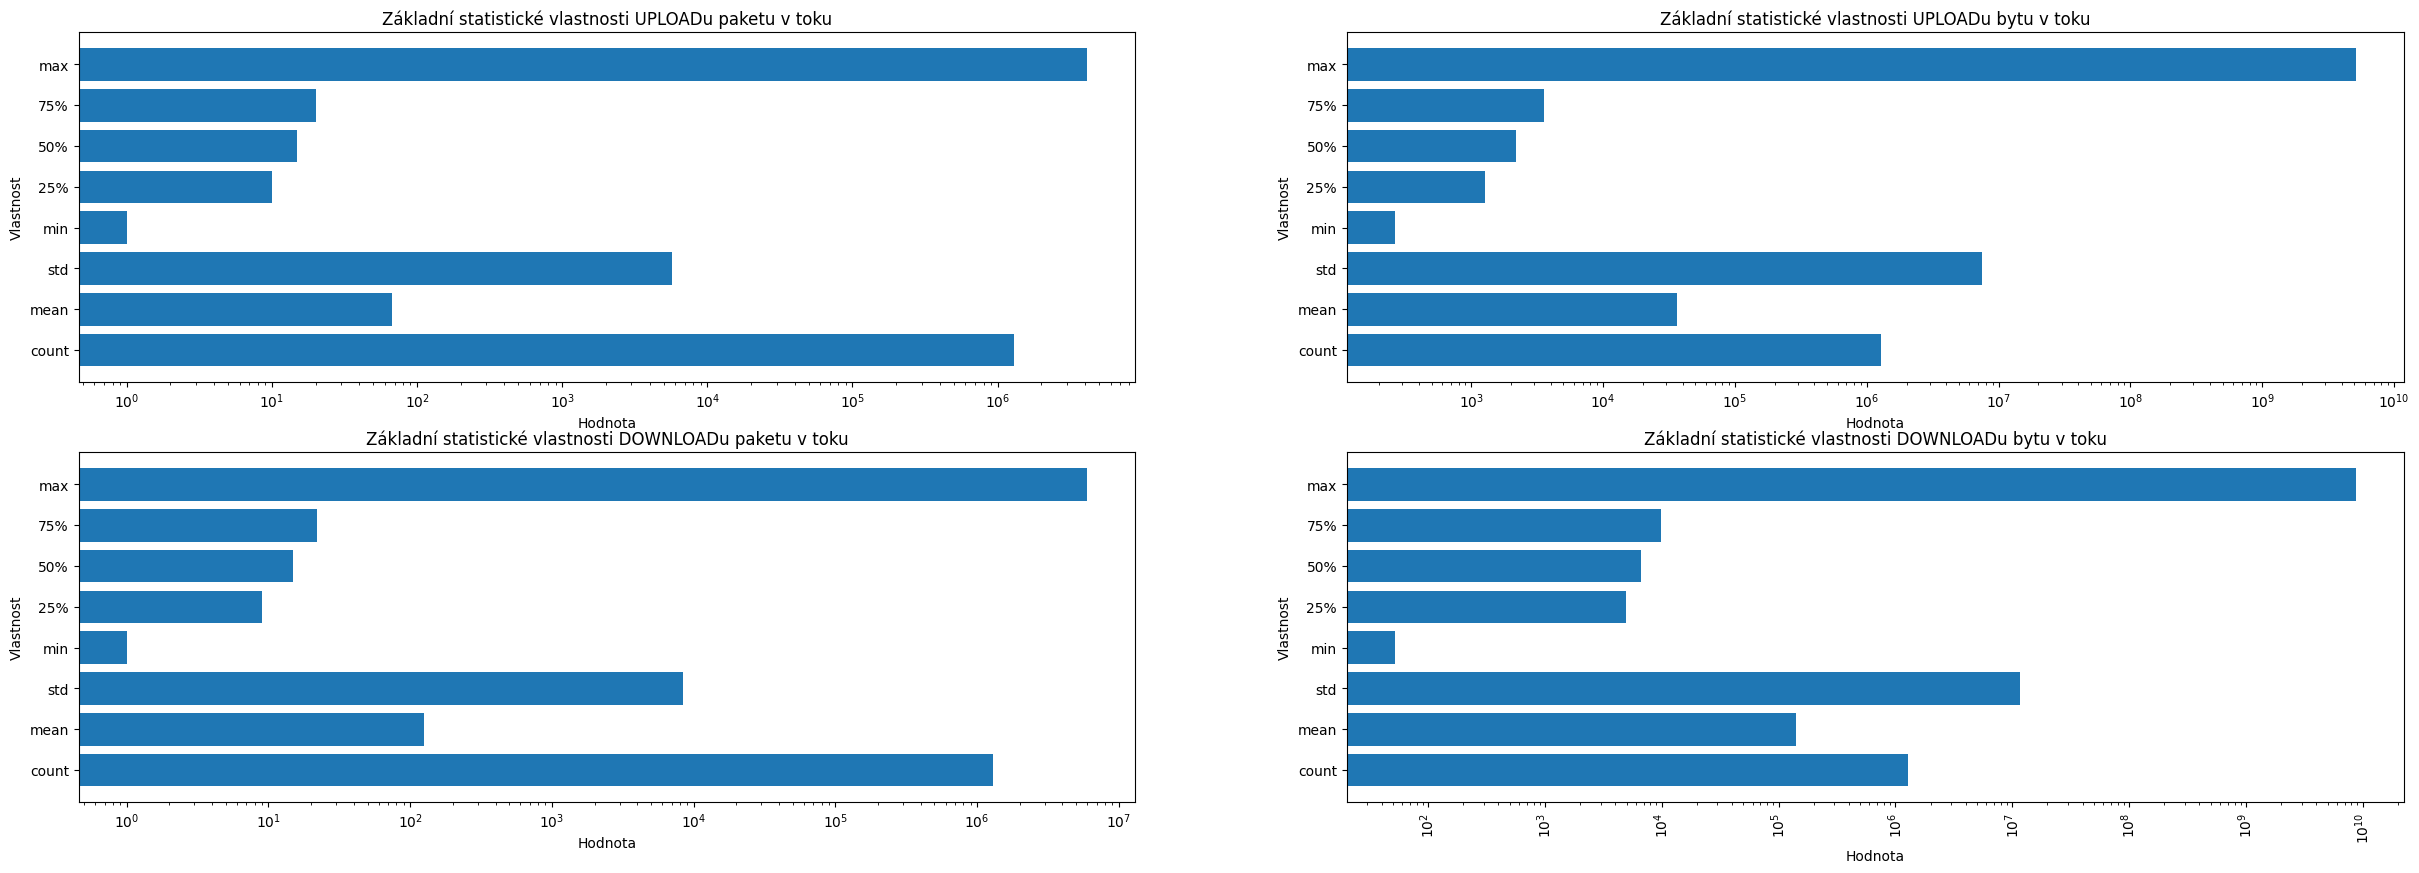

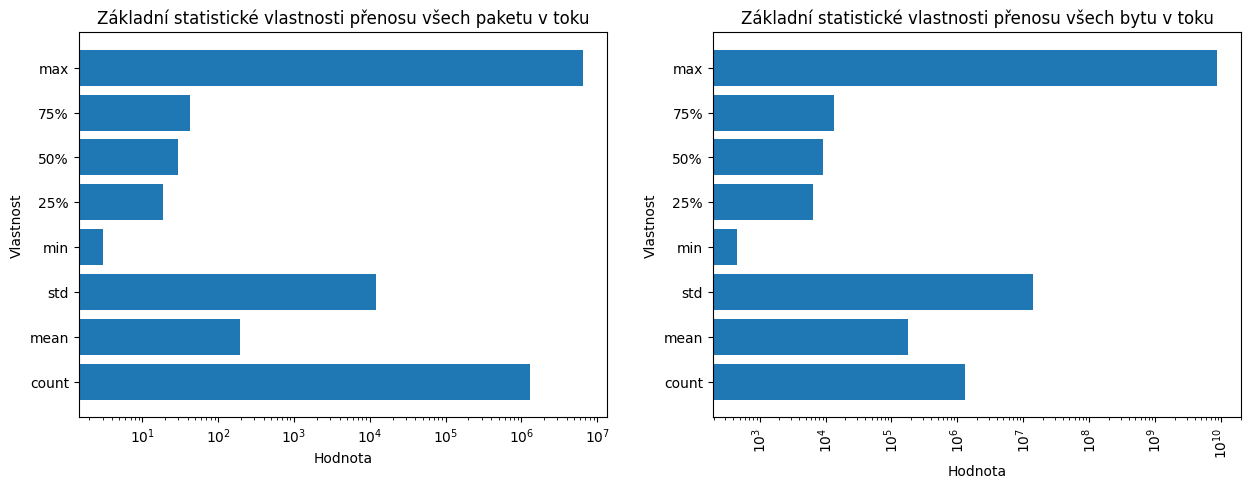

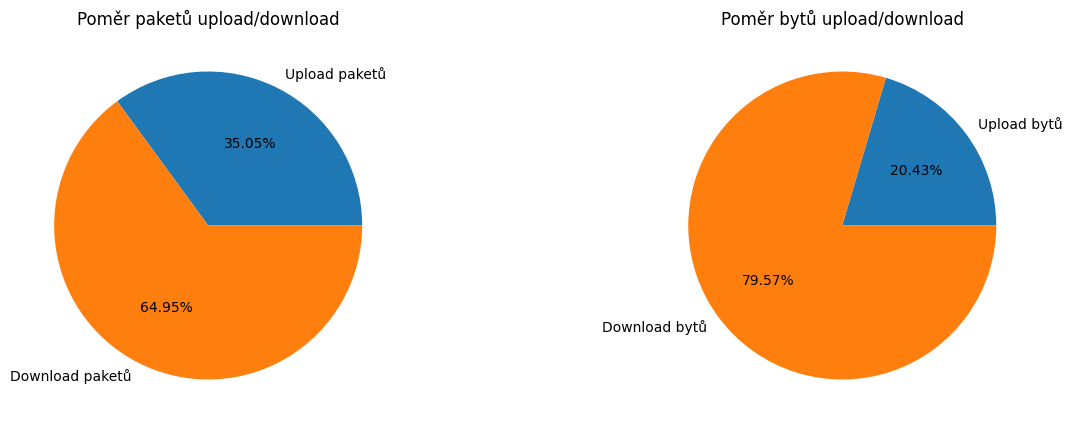

In [12]:
print("UPLOAD PACKETS:\n", df["PACKETS"].describe())
print("DOWNLOAD PACKETS:\n", df["PACKETS_REV"].describe())

df["TOTAL_PACKETS"] = df["PACKETS_REV"] + df["PACKETS"]
total_packets = df["TOTAL_PACKETS"]
print("TOTAL PACKETS:\n", total_packets.describe())

print("UPLOAD BYTES:\n", df["BYTES"].describe())
print("DOWNLOAD BYTES:\n", df["BYTES_REV"].describe())

df["TOTAL_BYTES"] = df["BYTES_REV"] + df["BYTES"]
total_bytes = df["TOTAL_BYTES"]
print("TOTAL BYTES:\n", total_bytes.describe())

# Celkovy pocet stazenych/nahranych paketu/bytu
total_down_pack = df["PACKETS_REV"].sum()
total_up_pack = df["PACKETS"].sum()

print("Celkem uploaded paketu", total_up_pack)
print("Celkem downloaded paketu", total_down_pack)

total_down = df["BYTES_REV"].sum()
total_up = df["BYTES"].sum()

print("Celkem uploaded bytu", total_up)
print("Celkem downloaded bytu", total_down)


# Tvorba obrazku ktery bude obsahovat 4 obrazky
# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots(2, 2, figsize=(30, 10))

# Tvorba grafu 1
ax[0][0].barh(df["PACKETS"].describe().index, df["PACKETS"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[0][0].set_title("Základní statistické vlastnosti UPLOADu paketu v toku")
ax[0][0].set_xlabel('Hodnota')
ax[0][0].set_ylabel('Vlastnost')

# Tvorba grafu vpravo nahore
ax[0][1].barh(df["BYTES"].describe().index, df["BYTES"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[0][1].set_title("Základní statistické vlastnosti UPLOADu bytu v toku")
ax[0][1].set_xlabel('Hodnota')
ax[0][1].set_ylabel('Vlastnost')

# Tvorba grafu vl;evo dole
ax[1][0].barh(df["PACKETS_REV"].describe().index, df["PACKETS_REV"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[1][0].set_title("Základní statistické vlastnosti DOWNLOADu paketu v toku")
ax[1][0].set_xlabel('Hodnota')
ax[1][0].set_ylabel('Vlastnost')

# Tvorba grafu vpravo dole
ax[1][1].barh(df["BYTES_REV"].describe().index, df["BYTES_REV"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[1][1].set_title("Základní statistické vlastnosti DOWNLOADu bytu v toku")
ax[1][1].set_xlabel('Hodnota')
ax[1][1].set_ylabel('Vlastnost')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()

# Tvorba obrazku ktery bude obsahovat 2 obrazky
# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Tvorba grafu 1
ax[0].barh( df["TOTAL_PACKETS"].describe().index,  df["TOTAL_PACKETS"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[0].set_title("Základní statistické vlastnosti přenosu všech paketu v toku")
ax[0].set_xlabel('Hodnota')
ax[0].set_ylabel('Vlastnost')

# Tvorba grafu vpravo nahore
ax[1].barh(df["TOTAL_BYTES"].describe().index, df["TOTAL_BYTES"].describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[1].set_title("Základní statistické vlastnosti přenosu všech bytu v toku")
ax[1].set_xlabel('Hodnota')
ax[1].set_ylabel('Vlastnost')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()



# Tvorba obrazku ktery bude obsahovat 2 obrazky
# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Tvorba grafu 1
ax[0].set_title("Poměr paketů upload/download")
ax[0].pie([total_up_pack, total_down_pack], labels=["Upload paketů", "Download paketů"], autopct='%1.2f%%');

# Tvorba grafu 2
ax[1].set_title("Poměr bytů upload/download")
ax[1].pie([total_up, total_down], labels=["Upload bytů", "Download bytů"], autopct='%1.2f%%');

# Zobrazeni obrazku
plt.show()



#### Statistické vlastnosti přenesených paketů
- Průměrný počet uploadu paketů na tok je **67.7**
- Průměrný počet downloadu paketů na tok je **125.43**.
- Je patrné, že se více data stahovalo než nahrávalo.
- Když tyhle 2 čísla sečteme, získáme statistiky o počtu paketů v celém toku, kde průměr byl **193.14**.
- Nejvíce paketů při stahování bylo **5.999 miliónu**. Při nahrávání to bylo **4.154 miliónu** v jednom toku. 
- **64.95%** všech paketů bylo ve směru server->klient, tedy beru jako download.

#### Statistické vlastnosti přenesených bytů
- Průměrný počet uploaded bytů na tok je **36 151.92**
- Průměrný počet downloaded bytů na tok je **140 818**.
- Potvrzuje se, že se více stahovalo než nahrávalo
- Nejvíce bytů při stahování bylo **8 693 279 000**. Při nahrávání pak **5 102 440 000**.
- **79.57%** všech bytů bylo ve směru server->klient, což opět odpovídá vyššímu downloadu.

<a id="minimum_packets"></a>
### Minimální počet paketů
Minimum pak byl 1 paket pro stahování i nahrávání. Zajímavé ale je, že když se sečtou pakety dohromady, minimální počet paketů v jednom toku je 3, tzn. tok nemohl nikdy poslat jen jeden paket v obou směrech. Na tento tok se zaměříme víc:

In [13]:
df.iloc[total_packets.idxmin()]

TLS_SNI                                                             dns.google
TIME_FIRST                                          2023-11-23 14:41:22.118979
TIME_LAST                                           2023-11-23 14:41:22.133218
PACKETS                                                                      2
PACKETS_REV                                                                  1
BYTES                                                                      629
BYTES_REV                                                                   60
TCP_FLAGS                                                                  198
PPI_PKT_DIRECTIONS                                                    [1|-1|1]
PPI_PKT_TIMES                [2023-11-23T14:41:22.118000|2023-11-23T14:41:2...
PPI_PKT_LENGTHS                                                      [517|0|0]
PPI_PKT_FLAGS                                                       [194|18|4]
TLS_SNI_DOMAIN_TOP                                  

#### Vlastnosti toku s minimálním počtem paketů
Zmínený tok má 2 pakety směrem k serveru (upload) a 1 zpět (download). Tyto pakety mají [TCP vlajky](https://en.wikipedia.org/wiki/Transmission_Control_Protocol) nastavené jako

- 194: CWR + ECE + SYN. CWR značí, že klient obdržel segment s ECE flagem a odpovídá kontrolou zahlcení. ECE a SYN značí, že klient podporuje ECN. SYN značí začátek komunikace - synchronizace sekvenčních čísel.
- 18: SYN + ACK. Server odpovídá na příchozí paket a potvrzuje sekvenční číslo klienta.
- 4: Klient komunikaci ukončuje pomocí RST.

Jedná se tedy o případ, kdy komunikace nebyla řádně ukončena.




### Korelace mezi přenesenými pakety a byty
Dále se podíváme na korelaci počtu přenesených paketů a bytů -- zda-li toky s více pakety obsahují í více bytů.



Korelace mezi celkovym poctem paketu a celkovym pcotem bytu: 0.8560696653201888
Korelace mezi nahranym poctem paketu a nahranym pcotem bytu: 0.8606105449797421
Korelace mezi stazenym poctem paketu a stazenym pcotem bytu: 0.7592006762194194


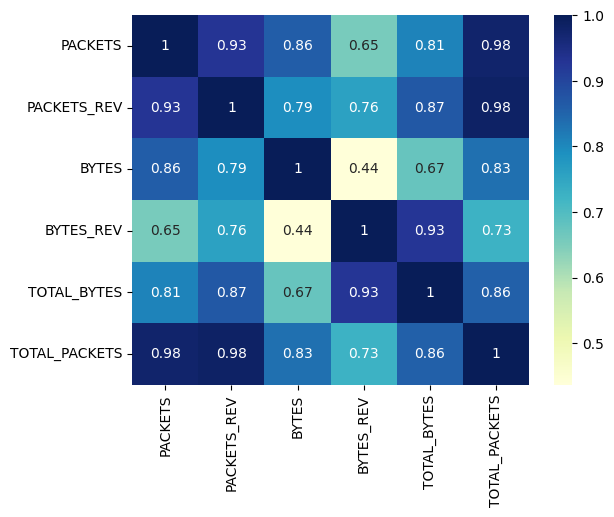

In [14]:
print("Korelace mezi celkovym poctem paketu a celkovym pcotem bytu:", total_packets.corr(total_bytes, method="spearman"))
print("Korelace mezi nahranym poctem paketu a nahranym pcotem bytu:", df["PACKETS"].corr(df["BYTES"], method="spearman"))
print("Korelace mezi stazenym poctem paketu a stazenym pcotem bytu:", df["PACKETS_REV"].corr(df["BYTES_REV"], method="spearman"))

# Vytvoreni noveho docasneho dataframu, do ktereho vlozim ty hodnoty, co chci korelovat
tmp_df = pandas.DataFrame()
tmp_df["PACKETS"] = df["PACKETS"]
tmp_df["PACKETS_REV"] = df["PACKETS_REV"]
tmp_df["BYTES"] = df["BYTES"]
tmp_df["BYTES_REV"] = df["BYTES_REV"]
tmp_df["TOTAL_BYTES"] = df["TOTAL_BYTES"]
tmp_df["TOTAL_PACKETS"] = df["TOTAL_PACKETS"]

# https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/
heatmap = seaborn.heatmap(tmp_df.corr(method="spearman"), cmap="YlGnBu", annot=True) 

#### Výsledky korelace
- [Spearmanova korelační metoda](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) říká, že čím je hodnota blíže 1 (nebo -1 pro negativní korelaci), tím jsou si data podobnější.
- Koeficient korelace **0.86** mezi celkovým počtem přenesených paketů a celkovým počtem přenesených bytů značí závislost
- Stejný koeificient korelace **0.86** popisuje i korelaci mezi nahranými pakety a nahranými byty
- 0.76 je koeficient korelace mezi staženými pakety a staženými byty.
- Z hodnot koeficientů vyplývá, že čím více paketů, tím více bytů - v obou směrech.


### Statistiky velikosti paketu v bytech
Dále se podíváme, jaký je průměrný počet bytů na jeden paket (v obou směrech, pak i v kontextu uploadu i downloadu).

Bytu na paket:
 count    1.287422e+06
mean     3.735655e+02
std      1.922569e+02
min      5.070246e+01
25%      2.552222e+02
50%      3.321958e+02
75%      4.206250e+02
max      1.466005e+03
dtype: float64
Bytu na paket - upload:
 count    1.287422e+06
mean     1.755208e+02
std      1.303597e+02
min      4.042141e+01
25%      1.105000e+02
50%      1.370667e+02
75%      1.910000e+02
max      1.497333e+03
dtype: float64
Bytu na paket - download:
 count    1.287422e+06
mean     5.318758e+02
std      3.024409e+02
min      4.037439e+01
25%      3.172671e+02
50%      4.842632e+02
75%      6.892857e+02
max      1.500391e+03
dtype: float64


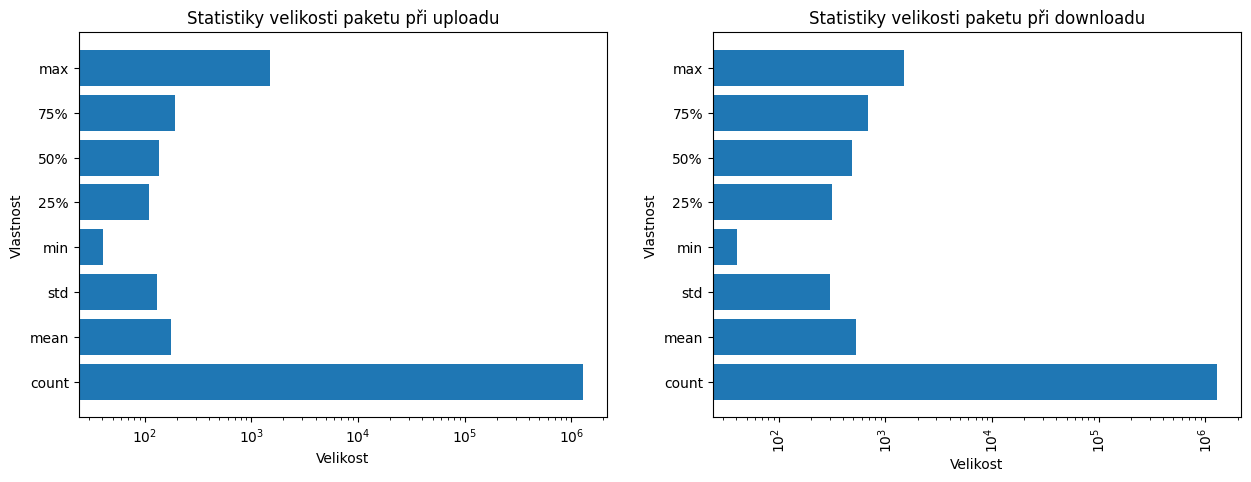

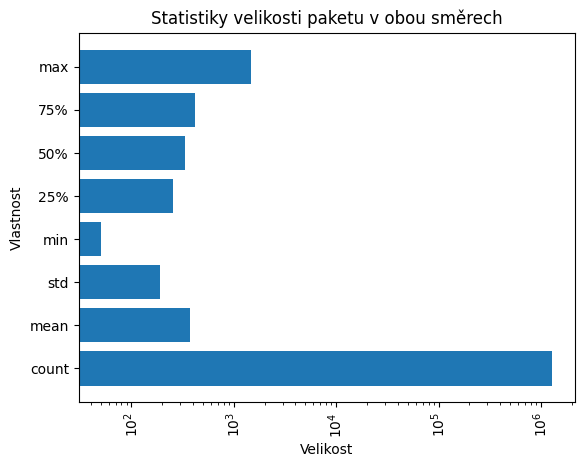

In [15]:
bytes_per_packet = df["TOTAL_BYTES"] / df["TOTAL_PACKETS"]
print("Bytu na paket:\n", bytes_per_packet.describe())

bytes_per_packet_up = df["BYTES"] / df["PACKETS"]
print("Bytu na paket - upload:\n", bytes_per_packet_up.describe())

bytes_per_packet_down= df["BYTES_REV"] / df["PACKETS_REV"]
print("Bytu na paket - download:\n", bytes_per_packet_down.describe())

# Tvorba obrazku ktery bude obsahovat 2 obrazky
# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Tvorba grafu 1
ax[0].barh( bytes_per_packet_up.describe().index,  bytes_per_packet_up.describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[0].set_title("Statistiky velikosti paketu při uploadu")
ax[0].set_xlabel('Velikost')
ax[0].set_ylabel('Vlastnost')

# Tvorba grafu vpravo nahore
ax[1].barh(bytes_per_packet_down.describe().index, bytes_per_packet_down.describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax[1].set_title("Statistiky velikosti paketu při downloadu")
ax[1].set_xlabel('Velikost')
ax[1].set_ylabel('Vlastnost')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()


# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots()

ax.barh( bytes_per_packet.describe().index,  bytes_per_packet.describe().values, log=True)

# Nastaveni popisu obrazku a os X a Y
ax.set_title("Statistiky velikosti paketu v obou směrech")
ax.set_xlabel('Velikost')
ax.set_ylabel('Vlastnost')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()

#### Interpretace statistik velikosti paketu
- Průměrný počet bytů na jeden paket je **373.56**.
- Nejvíce bytů na jeden paket bylo **1 466**.
- Ve směru klient->server pak byl počet bytů na paket průměrně **175,52** a maximálne **1 497**.
- V opačném směru to bylo průměrně **531.18** a maximálně **1 500**.
- Vypadá to, že nejnižší MTU po cestě bylo cca **1500** bytů.


Další zajímavě statistiky budou později v kontextu dalších sloupců.

## TCP_FLAGS
Vlajkami nastavenými v komunikaci (ve směru klient->server) se zabývá tato sekce.

### Výskyt flagů

count     1287422
unique         24
top            27
freq       893332
Name: TCP_FLAGS, dtype: object
TCP_FLAGS
27     893332
31     176312
30     115613
26      46772
219     32269
222     13536
223      8013
218      1379
95         44
19         30
6          30
198        23
211        16
23         12
2          12
215         8
159         8
194         3
94          3
22          2
18          2
187         1
214         1
210         1
Name: count, dtype: Int64


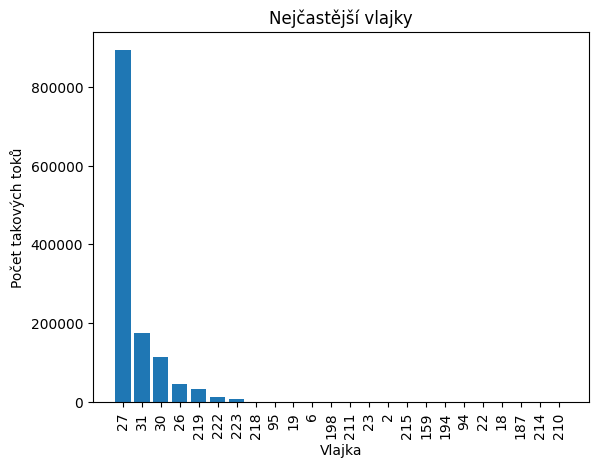

In [16]:
df["TCP_FLAGS"] = df["TCP_FLAGS"].astype("string") # Nemá cenu počítat průměr vlajek, musím se na to dívat jako na string, ne jako na numerickou hodnotu

print(df["TCP_FLAGS"].describe())
v_counts = df["TCP_FLAGS"].value_counts()
print(v_counts)

fig, ax = plt.subplots()

# Tvorba grafu vpravo
ax.bar(v_counts.index, v_counts.values)

# Nastaveni popisu obrazku a os X a Y
ax.set_title("Nejčastější vlajky")
ax.set_xlabel('Vlajka')
ax.set_ylabel('Počet takových toků')

# Otoceni osy X, at jsou adresy citelne
plt.xticks(rotation='vertical')

# Zobrazeni obrazku
plt.show()

#### Informace o výskytu flagů
- Ve všech tocích směrem k serveru je možné nalézt celkem 24 různých kombinací flagů.
- Nejčastější flagy v toku jsou 27 -- to znamená, že TCP flagy nastavené klientem v rámci toku byly ACK, PSH, SYN, FIN. Je pravděpodobné, že se v takovém případě jedná o komunikaci v podobě ze strany klienta řádně ukončeného (FIN) three-way handshaku (SYN+ACK), kdy klient žádal server o okamžité zaslání dat přes PSH.


### Metody ukončení toku
Dále se zaměříme na to, kolik toků bylo ukončeno ze strany uživatele přes RST, kolik přes FIN, kolik přes obojí a kolik vůbec.

Procento toků, kde došlo k ukončení přes RST:
 24.359145641444684
Procento toků, kde došlo k ukončení přes FIN:
 71.8993461351445
Procento toků, kde nedošlo k ukončení ani přes FIN ani přes RST:
 3.7415082234108166


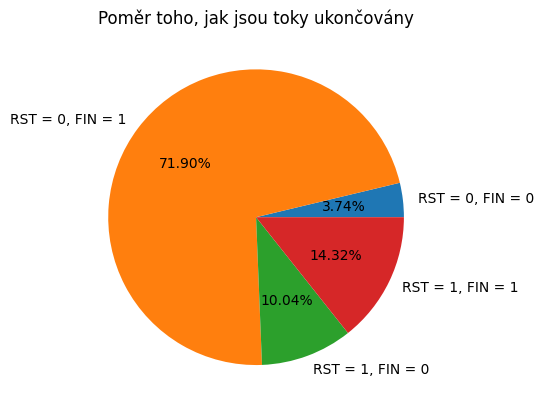

In [17]:
df["TCP_FLAGS"] = df["TCP_FLAGS"].astype("int")

FIN = 1
RST = 4
FINRST = 4+1

# & FINRST = RST - FIN nebyl setnuty, tzn. rst1 fin 0
rst1_fin0 = df[df["TCP_FLAGS"] & FINRST == RST]["TCP_FLAGS"].astype("string").value_counts().sum(numeric_only=True)

# RST = 0; FIN = 1
rst0_fin1 = df[df["TCP_FLAGS"] & FINRST == FIN]["TCP_FLAGS"].astype("string").value_counts().sum(numeric_only=True)

# RST = 0; FIN = 0
rst0_fin0 = df[df["TCP_FLAGS"] & FINRST == 0]["TCP_FLAGS"].astype("string").value_counts().sum(numeric_only=True)

# RST = 1; FIN = 1
rst1_fin1 = df[df["TCP_FLAGS"] & FINRST == FINRST]["TCP_FLAGS"].astype("string").value_counts().sum(numeric_only=True)

total = rst1_fin0 + rst0_fin1 + rst0_fin0 + rst1_fin1

print("Procento toků, kde došlo k ukončení přes RST:\n", ((rst1_fin1+rst1_fin0) / total) * 100)
print("Procento toků, kde došlo k ukončení přes FIN:\n", (rst0_fin1 / total) * 100)
print("Procento toků, kde nedošlo k ukončení ani přes FIN ani přes RST:\n", (rst0_fin0 / total) * 100)

# Tvorba obrazku ktery bude obsahovat 2 obrazky
# V Jupyter Notebooku ve webovem prostredi je mozne na obrazek 2x kliknout a zvetsi se
fig, ax = plt.subplots()

# Tvorba grafu 1
ax.set_title("Poměr toho, jak jsou toky ukončovány")
ax.pie([rst0_fin0, rst0_fin1, rst1_fin0, rst1_fin1], labels=["RST = 0, FIN = 0", "RST = 0, FIN = 1",\
                                                             "RST = 1, FIN = 0", "RST = 1, FIN = 1"], autopct='%1.2f%%');

# Zobrazeni obrazku
plt.show()




#### Počet nekorektně ukončených toků
- **10.04%** toků ukončili klienti pouze přes RST (RST = 1; FIN = 0)
- **14.36%** toků klienti ukončili použitím RST packetu i přesto, že již zaslali FIN (RST = 1, FIN = 1).
- **24.36%** toků celkem klienti ukončili použitím RST packetu (RST = 1, FIN = 1|0).
- **71.90%** toků bylo ukončeno přes FIN (FIN = 1; RST = 0)
- **3.74%** toků nebylo nijak ukončeno (FIN = 0; RST = 0)



<a id="ppi_solo_column"></a>
## PPI_*

Souhrnně popíšeme vlastnosti prvních 100 paketů toku. 

### Ověření validity HTTPS komunikace

Jelikož se jedná o HTTPS komunikaci, tak by měla být vždy iniciována klientem. Ověřím si, že neexistují nějaké anomálie.

In [18]:
values = pandas.DataFrame([df["PPI_PKT_DIRECTIONS"][x][1] for x in range(df.shape[0])])
print(values.describe())

              0
count   1287422
unique        1
top           1
freq    1287422


#### Validita komunikace --  komunikaci začíná klient
- Každý jeden tok je iniciován klientem (první hodnota v PPI_PKT_DIRECTION je 1) a tedy vypadá validně (HTTPS iniciuje klient).

### Začátek komunikace
Dále se zaměříme na to, jak vypadá první paket každého toku - měl by obsahovat SYN jakožto začátek TCP komunikace. Dále se pak zaměříme na to, jestli všechny komunikace obsahují three-way handshake, tedy budou načteny flagy prvních tří paketů. Ty budou testovány, zda obsahují v tomto pořadí SYN, SYN+ACK a ACK.

In [19]:
# Kontrola, ze kazdy paket zacina SYNem
values_flags = pandas.DataFrame([df["PPI_PKT_FLAGS"][x].split('|')[0][1:] for x in range(df.shape[0])]) # [194|...]
print(values_flags[0].unique())
print(values_flags[0].value_counts())

# Smery prvnich 3 paketu urcujici
values_directions = pandas.DataFrame([df["PPI_PKT_DIRECTIONS"][x][1:-1].split('|')[0:3] for x in range(df.shape[0])])

# Vlajky prvnich 3 paketu
values_flags = pandas.DataFrame([df["PPI_PKT_FLAGS"][x][1:-1].split('|')[0:3] for x in range(df.shape[0])])


['2' '194' '16']
0
2      1232203
194      55217
16           2
Name: count, dtype: int64


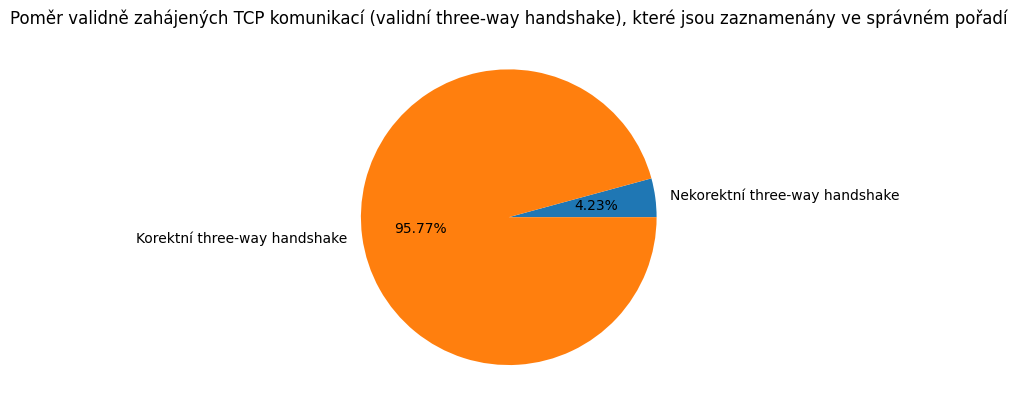

In [20]:
# Kontrola, ze pakety jsou ve smeru 1, -1, 1  a ze obsahuji postupne SYN, SYN+ACK, ACK
incorrect_tcp = 0
correct_tcp = 0

SYN = 2
ACK = 16
SYN_ACK = 18

half = values_directions.shape[0]/2
for i in range(values_directions.shape[0]):
    row_direction = values_directions.iloc[i]
    if (row_direction[0] == '1' and row_direction[1] == '-1' and row_direction[2] == '1'):
        row_flags = values_flags.iloc[i].astype("Int64")
        # SYN -> SYN+ACK -> ACK musi nasledovat po sobe
        if ((row_flags[0] & SYN == SYN) and (row_flags[1] &  SYN_ACK == SYN_ACK) and (row_flags[2] & ACK == ACK)):
            correct_tcp += 1
        else:
            incorrect_tcp += 1
    else:
        incorrect_tcp += 1

fig, ax = plt.subplots()

# Tvorba grafu 1
ax.set_title("Poměr validně zahájených TCP komunikací (validní three-way handshake), které jsou zaznamenány ve správném pořadí")
ax.pie([incorrect_tcp, correct_tcp], labels=["Nekorektní three-way handshake", "Korektní three-way handshake"], autopct='%1.2f%%');

# Zobrazeni obrazku
plt.show()





#### Výsledky validity začátku komunikace
- Komunikace vždy začíná s flagy 2, 194 nebo 16. 
- V případě, kdy začína s 194 nebo 2, obsahuje SYN a jedná se tedy nejspíš o začátek three-way handshaku. To je naprosto drtivá většina případů.
- Jsou však i dva případy, kdy komunikaci začína klient flagem ACK.
- Three-way handshake se úspěšně provedl v **95.77%** případů, tzn. první tři pakety toku byly SYN, SYN+ACK, ACK.
- V případě, kdy se nevykonal (**4.23%**), je možné, že buď došlo k chybě (viz např. zkoumání toku o pouze 3 paketech v sekci [PACKETS, PACKETS_REV, BYTES, BYTES_REV](#minimum_packets), nebo k nějaké anomálii (nesprávné pořadí paketu...).

### Anomálie v posloupnosti paketů
Na anomálie se zaměříme dále -- V naprosté většině případů začíná TCP komunikace alespoň paketem s flagem SYN. Ve dvou případech však ne. Na ty se zaměříme.

In [21]:
print(values_flags[values_flags[0] == '16'])

# Indexy ziskane z radku vyse
print(df.iloc[179606])
print(df.iloc[616387])

         0   1   2
179606  16   2  18
616387  16  16  16
TLS_SNI                                            googleads.g.doubleclick.net
TIME_FIRST                                          2023-11-23 14:49:47.500189
TIME_LAST                                           2023-11-23 14:51:17.983054
PACKETS                                                                     21
PACKETS_REV                                                                 21
BYTES                                                                     2932
BYTES_REV                                                                 8244
TCP_FLAGS                                                                   27
PPI_PKT_DIRECTIONS           [1|1|-1|1|1|-1|-1|-1|-1|-1|1|1|1|1|1|-1|-1|-1|...
PPI_PKT_TIMES                [2023-11-23T14:49:47.500000|2023-11-23T14:50:3...
PPI_PKT_LENGTHS              [0|0|0|0|579|0|1400|1400|1400|509|0|0|0|166|87...
PPI_PKT_FLAGS                [16|2|18|16|24|16|16|16|24|24|16|16|16|24|24|

#### Vysvětlení anomálií
- První tok začínající ACKem následuje SYN, opět poslaný klientem. Druhý případ obsahuje 3 ACKy po sobě. Ani jedno z toho není klasicky započatá TCP komunikace, ale jelikož na ni server reaguje, jedná se o pravděpodobně validní komunikaci, která byla buď špatně přiřazena do toku a nebo jsou pakety v nesprávném pořadí.
- Je možné, že se něco podobného (pakety přišly ve špatném pořadí) stalo vícekrát, což by vysvětlovalo relativně vysokou míru selhání three-way handshaku. 

### Pakety o velikosti 0
Dále se zaměříme na pakety o velikosti 0 v prvních 100 paketech. Takový paket nemá žádný payload, ale slouží pouze k tomu, aby o něčem informoval druhou stranu.

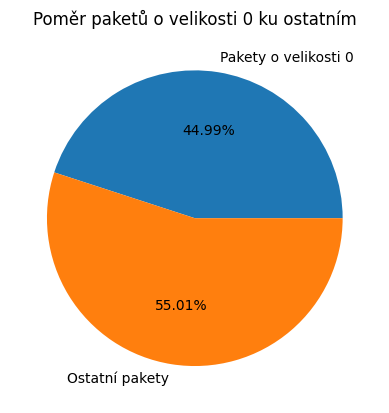

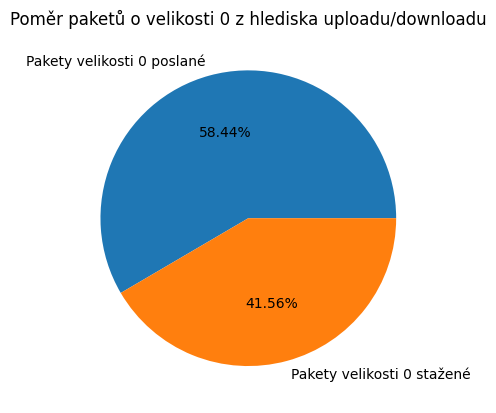

In [22]:
zeros = 0
zero_up = 0
zero_down = 0
elses = 0
for x in range(df.shape[0]):
    lengths = df["PPI_PKT_LENGTHS"][x][1:-1]
    vals = lengths.split("|")
    
    dirs = df["PPI_PKT_DIRECTIONS"][x][1:-1]
    dir_vals = dirs.split("|")
    index = 0
    for val in vals:
        if val == '0':
            if dir_vals[index] == '1': # upload
                zero_up += 1
            else: # download
                zero_down += 1 
            zeros += 1
        else:
            elses += 1
        index += 1

fig, ax = plt.subplots()
ax.pie([zeros, elses], labels=["Pakety o velikosti 0", "Ostatní pakety"], autopct='%1.2f%%');
ax.set_title("Poměr paketů o velikosti 0 ku ostatním");

fig, ax = plt.subplots()
ax.pie([zero_up, zero_down], labels=["Pakety velikosti 0 poslané", "Pakety velikosti 0 stažené"], autopct='%1.2f%%');
ax.set_title("Poměr paketů o velikosti 0 z hlediska uploadu/downloadu");


#### Množství signalizačních paketů
- **44.99%** paketů mezi prvními 100 poslanými napříč všemi toky má velikost **0**.
- Z těchto 45% je pak **58.44%** nulových paketů posílaných od klienta na server a **41.56%** od serveru na klienta.
- Lze konstatovat, že klienti signalizují druhou stranu více, než server klienty.

# Kombinace sloupců

Výše jsme analyzovali jednotlivé sloupce (případně v kombinaci se sloupci, se kterými přímo souvisí), následovat bude analýza v kontextu celého datasetu.

## TLS_SNI + TIME_*

Zaměříme se nejprve na průběh navazování nových toků dat ke konkrétním adresám v závislosti na čase. Jelikož je adres extrémně mnoho, zaměříme se jenom na 10 nejčastějších. Ty pak porovnáme s ostatními.

### Srovnání aktivity na adresách s nejvíce toky a aktivity na ostatních

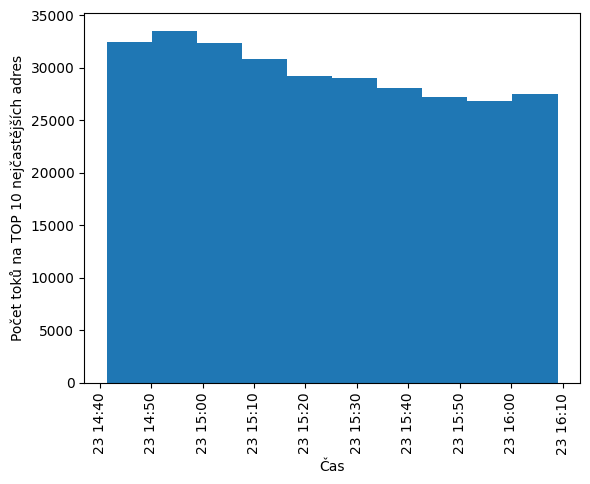

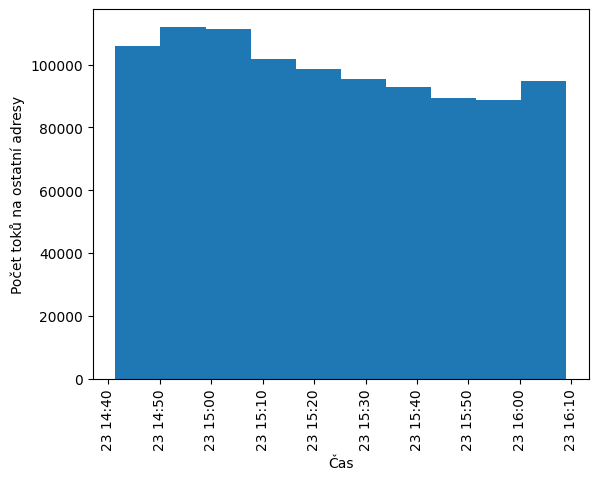

In [23]:
# Pocet hodnot, kolik nejpopularnejsich chci
n_of_vals = 10

value_counts = df["TLS_SNI"].value_counts()
top_n = value_counts.head(n_of_vals).index

# chci jen ty zaznamy, ktere maji TLS_SNI hodnotu tu nejcastejsi
filtered_top_n_df = df[df["TLS_SNI"].isin(top_n)]
filtered_last_m_df = df[~df["TLS_SNI"].isin(top_n)]

# Histogram
plt.hist(filtered_top_n_df["TIME_LAST"], bins=10)
plt.xlabel('Čas')
plt.ylabel('Počet toků na TOP 10 nejčastějších adres')
plt.xticks(rotation='vertical')

plt.show()

plt.hist(filtered_last_m_df["TIME_LAST"], bins=10)
plt.xlabel('Čas')
plt.ylabel('Počet toků na ostatní adresy')
plt.xticks(rotation='vertical')

plt.show()

#### Aktivita na 10 nejpopulárnějších adresách oproti ostatním
- Počet toků na TOP 10 stránek má obdobný graf jako počet toků na ostatní stránky napříč celým datasetem.
- Klesající trend pravděpodobně souvisí obecně s klesající aktivitou uživatelů v průběhu odpoledne.

### Aktivita v tocích souvisejících s Googlem
Dále se zaměřím na služby od googlu, které mají největší zastoupení, a porovnám je s ostatními toky.

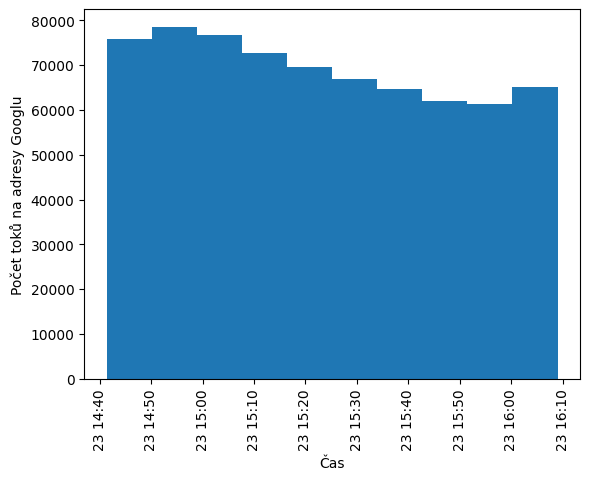

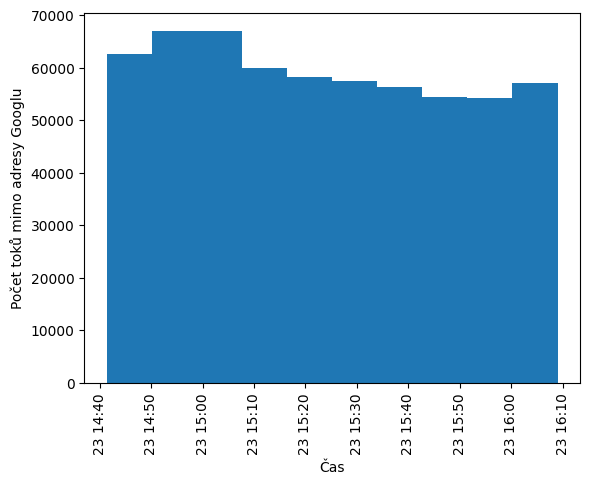

In [24]:
# zaznamy jen od google sluzeb
googles = df[df["TLS_SNI"].str.contains("google")]
not_googles = df[~df["TLS_SNI"].str.contains("google")]


plt.hist(googles["TIME_LAST"], bins=10)
plt.xlabel('Čas')
plt.ylabel('Počet toků na adresy Googlu')
plt.xticks(rotation='vertical')

plt.show()

plt.hist(not_googles["TIME_LAST"], bins=10)
plt.xlabel('Čas')
plt.ylabel('Počet toků mimo adresy Googlu')
plt.xticks(rotation='vertical')

plt.show()

#### Vyhodnocení aktivity na Google službách
- Z výsledků je patrné, že se opět oba grafy velmi podobají. Snad jen že aktivita u stránek/služeb googlu klesá o něco více, zatímco aktivita na ostatních stránkách klesá pomaleji.
- Z porovnání aktivity na jednotlivých stránkách a času vyplývá, že aktivita uživatelů skrze ubíhající čas klesá nezávisle na navštěvovaných stránkách -- snad jen že na stránkách souvisejících s Googlem klesá o něco rychleji.

### Doby toku na adresy
Dále se podíváme na průměrnou dobu, jakou trvaly toky k jednotlivým adresám -- které adresy měly průměrně nejdelší toky a jaká je celková doba, po kterou existoval otevřený tok s danou adresou. V souvislosti s tím se podíváme i na toky s celkovou nejvyšší dobou existence toků.

In [25]:
n_of_vals = 10

# group podle nazvu, sectu vsechny casy
times_total_opened = df.groupby("TLS_SNI")["TIMES"].sum()
print("Celkove mnozstvi casu po ktery byl otevren tok s danou adresou")
print(times_total_opened.nlargest(n_of_vals))

times_average_opened = df.groupby("TLS_SNI")["TIMES"].mean()
print("Prumerny cas po ktery byl otevren tok s danou adresou")
print(times_average_opened.nlargest(n_of_vals))


Celkove mnozstvi casu po ktery byl otevren tok s danou adresou
TLS_SNI
mail.google.com                   21 days 09:38:14.714985
fonts.gstatic.com                 19 days 11:11:46.972129
www.google.com                    18 days 08:55:01.862824
play.google.com                   17 days 08:52:44.161596
signaler-pa.clients6.google.com   16 days 14:05:45.191882
www.gstatic.com                   15 days 00:20:54.396542
ssl.gstatic.com                   13 days 15:20:57.725655
www.googletagmanager.com          12 days 10:09:43.884030
dns.google                        12 days 06:03:58.771298
content-autofill.googleapis.com   11 days 11:38:35.145506
Name: TIMES, dtype: timedelta64[us]
Prumerny cas po ktery byl otevren tok s danou adresou
TLS_SNI
8.8.4.4                                                            0 days 01:00:00.398135
io.dns.service.paloaltonetworks.com                                0 days 00:57:19.993994
io.prod.fiveable.me                                                0 da

#### Aktivita toků na adresách
- Nejvíce času byly otevřen toky s mailovým klientem od Googlu.
- Následovaly další služby od Googlu, přičemž všech 10 služeb, které mělůy toky otevřené nejdéle, je od Googlu.
- Průměrně nejdelší tok má adresa je 8.8.4.4, což je DNS server od Googlu. Je však zvláštní, že je uveden jako IP adresa namísto URL. Je tedy možné, že se jedná o další anomálii.


## TLS_SNI + PACKETS* | BYTES*

Dále se podíváme na vztah v podobě adresa<->počet_paketů.

Cílem bude zjistit, které služby jsou nejaktivnější co se posílaných (a získávaných) paketů týče. 

### Nejaktivnější adresy z hlediska počtu přenesených paketů
Zaměříme se na 10 nejvíce aktivních v počtu stažených/odeslaných paketů a v celkovém počtu paketů.

In [26]:
n_of_vals = 10

# group podle nazvu, udelam sumu vsech paketu v tocich na adresu
sni_packet_totals = df.groupby("TLS_SNI")["TOTAL_PACKETS"].sum()

print("Pocet celkove prenesenych paketu na adresu")
print(sni_packet_totals.nlargest(n_of_vals))

Pocet celkove prenesenych paketu na adresu
TLS_SNI
www.googleapis.com                      24896311
www.google.com                           7444563
doc-04-0o-docs.googleusercontent.com     6518895
peoplestack-pa.googleapis.com            6354387
cz-bks400-prod11-live.solocoo.tv         6093424
cz-bks400-prod15-live.solocoo.tv         5973214
8.dl.wsfiles.cz                          5954103
v01.kra.sk                               5769531
www201.uschovna.cz                       5430552
mail.google.com                          5398412
Name: TOTAL_PACKETS, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu přenesených paketů
- Stránka s nejvíce toky je www.google.com (viz sekce [základní statistiky](#most_common_addresses)) .
- Co se ale počtu přenesených paketů týče, tak zdaleka nejvíce má www.googleapis.com a www.google.com je až druhý.
- Celkově je ale v TOP 10 celkem 5x stránka související s googlem, což dokládá to, jak moc je využívaný. 
- Dále se zde pak nacházejí služby solocoo.tv, což je nejspíše služba na přenos živého TV vysílání, takže dává smysl, že přenáší mnoho paketů. Ostatní jsou pak služby pro úschovu/stažení souborů, takže opět dává smysl, že přenášejí velké množství paketů.

Ověřím si, že tomuto odpovídá i počet přenesených bytů:

In [27]:
# group podle nazvu, udelam sumu vsech paketu v tocich na adresu
sni_byte_totals = df.groupby("TLS_SNI")["TOTAL_BYTES"].sum()

print("Pocet celkove prenesenych bytu na adresu")
print(sni_byte_totals.nlargest(n_of_vals))

Pocet celkove prenesenych bytu na adresu
TLS_SNI
www.googleapis.com                      23186743949
doc-04-0o-docs.googleusercontent.com     8718081652
8.dl.wsfiles.cz                          8073688074
cz-bks400-prod11-live.solocoo.tv         7132847696
cz-bks400-prod15-live.solocoo.tv         6906414625
v01.kra.sk                               6765041828
www.jh-inst.cas.cz                       6592265764
www201.uschovna.cz                       5913658802
cz-bks400-prod04-live.solocoo.tv         5879496277
peoplestack-pa.googleapis.com            5245418213
Name: TOTAL_BYTES, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu přenesených bytů
- www.google.com už z TOP 10 vypadnul úplně, ovšem ostatní předchozí stránky zde vesměs zůstaly, jen v jiném pořadí.
- Dává smysl, že vyhledávač nepřenáší tolik bytů co živé vysílání televize či stahování souborů.
- Zdaleka první jsou opět googleapis, které krom paketů přenáší i ohromné množství dat.

Nyní se podíváme na pakety a bity poslané jako upload.

In [28]:
sni_packet_upload = df.groupby("TLS_SNI")["PACKETS"].sum()

print("Pocet nahranych paketu na adresu")
print(sni_packet_upload.nlargest(n_of_vals))

Pocet nahranych paketu na adresu
TLS_SNI
www.googleapis.com                  15832226
peoplestack-pa.googleapis.com        4202453
www201.uschovna.cz                   2987493
www.google.com                       2565360
mail.google.com                      1855980
photos.googleapis.com                1791371
cz-bks400-prod15-live.solocoo.tv     1397918
www.youtube.com                      1370232
cz-bks400-prod04-live.solocoo.tv     1367471
cz-bks400-prod11-live.solocoo.tv     1357704
Name: PACKETS, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu odeslaných paketů
- Googleapis se v počtu odeslaných paketů drží opět na vrcholu.
- Co může být poněkud zajímavé tak je, že se zde objevily youtube i zmíněný televizní přenos. Jelikož se ovšem jedná o přenos velkého množství různých dat, může to být způsobené např. více toky současně, kdy každý obsahuje jiné informace.

Dále se podíváme, jestli tomu odpovídá i množství odeslaných bytů:

In [29]:
sni_byte_upload = df.groupby("TLS_SNI")["BYTES"].sum()

print("Pocet nahranych bytu na adresu")
print(sni_byte_upload.nlargest(n_of_vals))

Pocet nahranych bytu na adresu
TLS_SNI
www.googleapis.com                   21584592582
peoplestack-pa.googleapis.com         5109850887
www201.uschovna.cz                    4116946918
photos.googleapis.com                 2432512944
play.google.com                        993545640
mail.google.com                        769660049
taskassist-pa.clients6.google.com      691183088
www.google.com                         579749069
photosdata-pa.googleapis.com           446454120
www202.uschovna.cz                     422458815
Name: BYTES, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu odeslaných bytů
- Počty odeslaných bytů jednoznačně dominují služby od Googlu.
- Už zde není přítomno televizní vysílání ani youtube, které používají odesílané pakety pravděpodobně pro kontrolní účely namísto odesílání dat.

Nyní na stažené pakety:

In [30]:
sni_packet_download = df.groupby("TLS_SNI")["PACKETS_REV"].sum()

print("Pocet stazenych paketu na adresu")
print(sni_packet_download.nlargest(n_of_vals))

Pocet stazenych paketu na adresu
TLS_SNI
www.googleapis.com                      9064085
doc-04-0o-docs.googleusercontent.com    5999166
8.dl.wsfiles.cz                         5368537
www.google.com                          4879203
cz-bks400-prod11-live.solocoo.tv        4735720
v01.kra.sk                              4593918
cz-bks400-prod15-live.solocoo.tv        4575296
www.jh-inst.cas.cz                      4383516
cz-bks400-prod04-live.solocoo.tv        3964010
mail.google.com                         3542432
Name: PACKETS_REV, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu stažených paketů
- V počtu stažených paketů je opět na prvním míste googleapis, ovšem zde už vedení není ani zdaleka tak výrazné jako předtím.
- Opět se zde vyskytují další služby od googlu a pravděpodobný přenos televizního vysíláním což by odpovídalo tomu, že se primárně data stahují.

Nyní na stažené byty:

In [31]:
sni_byte_download = df.groupby("TLS_SNI")["BYTES_REV"].sum()

print("Pocet stazenych bytu na adresu")
print(sni_byte_download.nlargest(n_of_vals))

Pocet stazenych bytu na adresu
TLS_SNI
doc-04-0o-docs.googleusercontent.com    8693278728
8.dl.wsfiles.cz                         8049440150
cz-bks400-prod11-live.solocoo.tv        7056552928
cz-bks400-prod15-live.solocoo.tv        6821890712
v01.kra.sk                              6717297112
www.jh-inst.cas.cz                      6570033256
cz-bks400-prod04-live.solocoo.tv        5796912851
www.google.com                          4520474651
cz-bks400-prod03-live.solocoo.tv        3879218547
cz-bks400-prod08-live.solocoo.tv        3598753609
Name: BYTES_REV, dtype: int64


#### 10 nejaktivnějších adres z hlediska počtu stažených bytů
- V počtu stažených bytů už se Googleapis neudržel ani mezi 10 nejpoužívanějšími.
- To může značit, že se v rámci googleapis volání o data více žádá, než se jich stahuje. 
- Je zde mnohokrát přítomno televizní vysílání, což je očekávatelné, ale v TOP 10 není přítomna služba Youtube.com, kterou bychom zde mohli očekávat, jelikož patří mezi služby s nejvíce zaznamenanými toky. Je ale pravděpodobné, že tyto toky se vytvářejí nikoliv za účelem pouze přenosu videa, ale i přenosu dalších mnoha součástí stránky.

### Přenos paketů a bytů u Google služeb
Zmiňoval jsem v popisu TLS_SNI, že služby Googlu tvoří skoro 54% všech zaznamenaných toků. Zkusíme tedy změřit, jak jsou na tom služby google z hlediska celkového počtu přenesených paketů a bytů. 

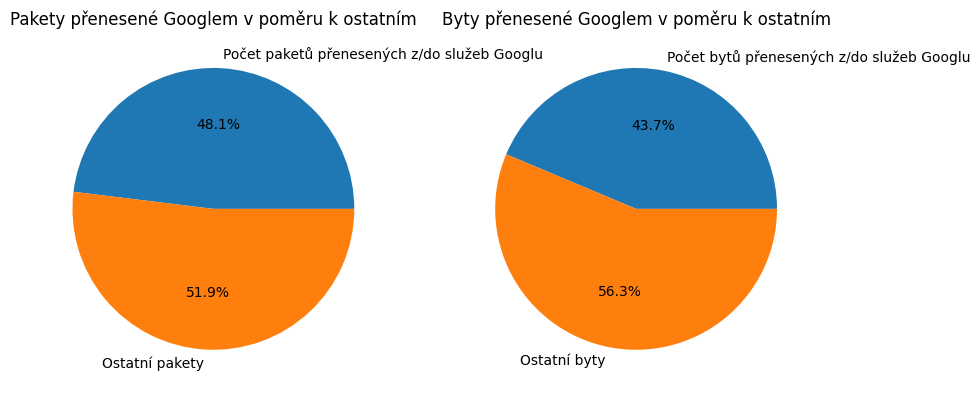

In [32]:
googles = df[df["TLS_SNI"].str.contains("google")]

total_packets = df["TOTAL_PACKETS"].sum()
total_bytes = df["TOTAL_BYTES"].sum()

google_packets = (googles["PACKETS_REV"] + googles["PACKETS"]).sum()
google_bytes = (googles["BYTES_REV"] + googles["BYTES"]).sum()


fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].pie([google_packets, total_packets - google_packets], labels=["Počet paketů přenesených z/do služeb Googlu", "Ostatní pakety"], autopct='%1.1f%%');
ax[0].set_title("Pakety přenesené Googlem v poměru k ostatním");

ax[1].pie([google_bytes, total_bytes - google_bytes], labels=["Počet bytů přenesených z/do služeb Googlu", "Ostatní byty"], autopct='%1.1f%%');
ax[1].set_title("Byty přenesené Googlem v poměru k ostatním");

#### Vyhodnocení přenesených paketů/bytů službami od Google.
- Je patrné, že zatímco v počtu toků mají služby Googlu nadpoloviční většinu (viz. sekce [TLS_SNI](#google_adresy)), co se přenesených paketů i bytů týče, jsou v menšině.
- Lze také vidět, že služby Googlu přenášejí více paketů v poměru k celkovému počtu přenesených paketů oproti poměru v bytech. 

## TLS_SNI + TCP_FLAGS

### Která služba nejčastěji končí přes RST
Zde se objevuje otázka, která služba je nejvíce ukončována klientem přes RST. To se dozvíme za pomoci buňky níže:

In [33]:
# jenom ty toky ukoncene RST
reset = df[df["TCP_FLAGS"] & RST == RST]

# pocet zaznamu pro kazdy TLS_SNI ukonceny RST
most_ended = reset["TLS_SNI"].value_counts()

print("Adresy nejvice ukoncovane na RST:")
print(most_ended.nlargest(n_of_vals))

Adresy nejvice ukoncovane na RST:
TLS_SNI
dns.google                         13619
www.google.com                     12937
doh.opendns.com                    10755
mail.google.com                     8867
safebrowsing.googleapis.com         8495
fonts.gstatic.com                   5853
gew1-spclient.spotify.com           5817
notifications-pa.googleapis.com     5493
www.googleapis.com                  5447
inbox.google.com                    4776
Name: count, dtype: int64


#### Nejčastěji ukončované toky přes RST v souvislosti s adresou služby
- Nejvíce jsou přes RST ukončované toky k DNS serverům. 8/10 nejčastěji resetovaných pak tvoří různé služby od Googlu.

## TLS_SNI + PPI_*

### Hledání, zda se liší nulové pakety u nejčastějších služeb oproti ostatním
Analyzujeme, jestli se prvních 10 služeb z hlediska počtu toků, nějak liší z hlediska nulových paketů v prvních 100 paketech toku oproti zbytku datasetu.

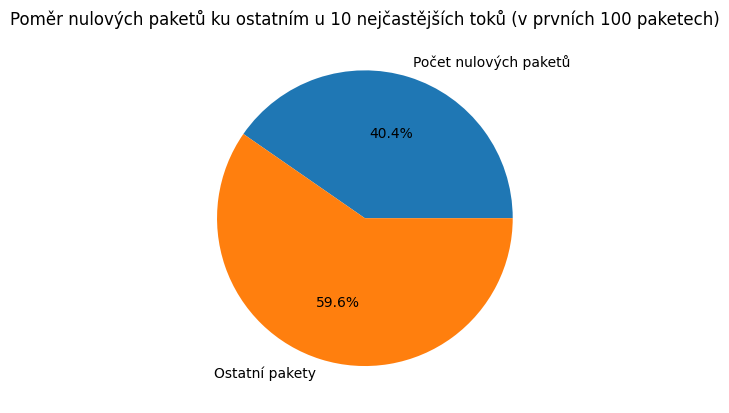

In [34]:
zeros = 0
zero_up = 0
zero_down = 0
elses = 0

n_of_results = 10


val_counts = df["TLS_SNI"].value_counts()

# Nty vysledek na indexu N - 1
n_th_largest = val_counts.nlargest(n_of_results).iloc[n_of_results-1]

# Vyfiltruj pocet vyskytu tam, kde je >= top N
val_counts = val_counts[val_counts >= n_th_largest]

only_top_n = df[df["TLS_SNI"].isin(val_counts.index)]

total_sum_zeros = 0
total_sum_else = 0
grouped_lengths = only_top_n.groupby("TLS_SNI", group_keys=True)["PPI_PKT_LENGTHS"]

for x, y in grouped_lengths:
    total_sum_zeros += y.apply(lambda x: sum(1 for val in x.split('|') if val == '0')).sum()
    total_sum_else += y.apply(lambda x: sum(1 for val in x.split('|') if val != '0')).sum()

fig, ax = plt.subplots()

ax.pie([total_sum_zeros, total_sum_else], labels=["Počet nulových paketů", "Ostatní pakety"], autopct='%1.1f%%');
ax.set_title("Poměr nulových paketů ku ostatním u 10 nejčastějších toků (v prvních 100 paketech)");


#### Nejčastější služby odpovídají celku
- Jak lze vidět z grafu, poměr je podobný tomu, který byl určen napříč celým datasetem v sekci [PPI_*](#ppi_solo_column)

## TIME_\* + PACKETS\* | BYTES\*

Zde se zaměřím na počet přenesených paketů a bytů za daný čas -- konkrétně na čas potřebný pro přenos 1 paketu. 

### Kolik času je potřeba na přenos bytu

In [35]:
# Kolik casu potreboval 1 paket - max/min/mean
df["PACKET_DELAY"] = df["TIMES"] / df["TOTAL_PACKETS"]

time_per_packet = df.groupby("TLS_SNI")["PACKET_DELAY"].mean()
print("\nPrumerna doba potrebna pro prenos jednoho paketu v toku - nejvyssi:\n")
print(time_per_packet.nlargest(n_of_vals))
print("\nPrumerna doba potrebna pro prenos jednoho paketu v toku - nejnizsi:\n")
print(time_per_packet.nsmallest(n_of_vals))

time_per_packet = df.groupby("TLS_SNI")["PACKET_DELAY"].max()
print("\nMaximalni doba potrebna pro prenos jednoho paketu v toku:\n")
print(time_per_packet.nlargest(n_of_vals))
print("\nMinimalni doba potrebna pro prenos jednoho paketu v toku - nejnizsi:\n")
print(time_per_packet.nsmallest(n_of_vals))

print("\nPrumerna hodnota pro prenos paketu napric datasetem:\n")
print(df["PACKET_DELAY"].mean())


Prumerna doba potrebna pro prenos jednoho paketu v toku - nejvyssi:

TLS_SNI
18ab4ac547138952803f59d3763f010b.safeframe.googlesyndication.com   0 days 00:00:11.156217
www-daniweb-com.webpkgcache.com                                    0 days 00:00:11.155768
7c9f67887fa70e95fd0862b10dcbbc03.safeframe.googlesyndication.com   0 days 00:00:10.372489
netpincer-1239.firebaseio.com                                      0 days 00:00:10.038332
o1220318.ingest.sentry.io                                          0 days 00:00:09.778520
5e44e792d6c322ce88a33c13b3eceba4.safeframe.googlesyndication.com   0 days 00:00:09.703976
ccef1405e18f0a572c76f416de928b74.safeframe.googlesyndication.com   0 days 00:00:09.670780
5d9f301c6293151909c63282e0940f67.safeframe.googlesyndication.com   0 days 00:00:09.670681
8025112df4c3e9af33f31279586dfffd.safeframe.googlesyndication.com   0 days 00:00:09.669876
ecf502167d6ebed4e5a4066050029f2d.safeframe.googlesyndication.com   0 days 00:00:09.669134
Name: PACKET_DELAY, dt

#### Doba pro přenos jednoho bytu
- Je patrné, že průměrná doba, po jakou se přenášel paket v rámci toku k jednoitlivým adresám, se výrazně liší u minimálních a maximálních hodnot.
- Zatímco nejvíce se v průměru čekalo i **11** vteřin na přenos paketu, u nejrychlejších bylo pro přenos paketu potřeba pouze **0.000055** vteřiny.
- Když se zaměříme na extrémy, je patrné, že nejdéle se v rámci 1 toku čekalo na paket skoro **17** vteřin.
- Nejrychlejší tok pak potřeboval pouze zmíněných **0.000055** sekundy na paket. Jelikož se tato hodnota už však vyskytla i u průměru, znamená to, že k tomuto zdaleka nejrychlejšímu serveru se uživatel v síti připojil pouze jednou.
- Celková průměrná doba, po kterou trvalo přenést jeden paket, pak byla napříč celým datasetem 0.9 vteřiny.


## PACKETS* | BYTES* + TCP_FLAGS

Tato sekce se zaměří na to, kolik bytů bylo přeneseno v tocích, které byly ukončeny přes RST ze strany klienta a kolik ve všech ostatních.

### Přenos bytů v tocích ukončených RST
Bylo ukončeno přes RST celkem **~24%** všech toků. Tato sekce zodpoví, zda tento podíl bude podobný i počtu paketů a množství přenesených bytů v těchto tocích.

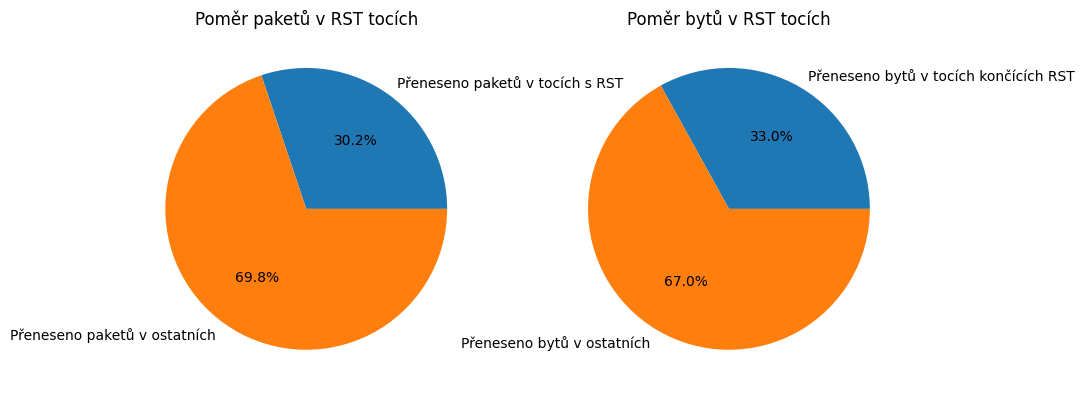

In [36]:
reset = df[df["TCP_FLAGS"] & RST == RST]
not_reset = df[df["TCP_FLAGS"] & RST == 0] # 11 = 1011 | 4 = 0100 = 0000

total_bytes_rst = reset["TOTAL_BYTES"].sum()
total_bytes_not_rst = not_reset["TOTAL_BYTES"].sum()

total_packets_rst = reset["TOTAL_PACKETS"].sum()
total_packets_not_rst = not_reset["TOTAL_PACKETS"].sum()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].pie([total_packets_rst, total_packets_not_rst], labels=["Přeneseno paketů v tocích s RST", "Přeneseno paketů v ostatních"], autopct='%1.1f%%');
ax[0].set_title("Poměr paketů v RST tocích");

ax[1].pie([total_bytes_rst, total_bytes_not_rst], labels=["Přeneseno bytů v tocích končících RST", "Přeneseno bytů v ostatních"], autopct='%1.1f%%');
ax[1].set_title("Poměr bytů v RST tocích");



#### Byty přenesené v tocích končících RST
- Jak lze vidět, na to, že toky zakončené RST zprávou tvoří jen zmíněných **~24%** všech toků, tak obsahují **30.2%** všech paketů a dokonce **33%** všech přenesených bytů.

### a) Jaké jsou charakteristické rysy dat? Je v datech něco specifického?

- Charakteristické pro data v daném datasetu je, že jdou více ve směru server->klient než klient->server. V této analýze jsem nahlížel na upload/download podle toho, kterým směrem paket mířil. Download tvořil **64.95%** veškerých přenesených paketů a dokonce **79.57%** všech přenesených bytů.

- Dále je pro pakety typické, že míří k již známé adrese - **98.25%** všech zaznamenaných toků bylo s již známou adresou. Jako známe adresy byly považovány ty, které mají k sobě přiřazeno alespoň 5 toků. Tyto adresy ale tvoří pouhých **16.22%** všech záznamů -- většina adres v datasetu má k sobě asociováno méně než 5 toků. Ty, se kterými se toky ustanovují opakovaně, tak pak ale z hlediska počtu těchto toků vysoce dominují.

- Většina toků vede na adresu končící ``.com``. Komunikace s adresami s TLD ``.com`` tvoří více než **80%** veškeré komunikace. Nejčastější subdomény pak tvoří různé subdomény spojené s Googlem

- Více než polovina všech toků má spojitost se službami od Googlu.

- Data byla sbírána po dobu 1h 27m 40.16s. Většina toků se délkou vešla pod 4 vteřiny.

- Průměrný počet paketů na jeden tok je ~194.

- Většina toků je zakončena FINem. Skoro 25% ovšem přes RST. Skoro 4% toků ovšem nejsou ukončeny nijak (ani RST, ani FIN)

- Většina adres je ve formátu URL. Výjimečně se však objevují i adresy v podobě IP.

- 45% paketů v prvních 100 poslaných paketech každého toku má velikost 0

- 95.77% dat má jako první tři pakety toku Three-Way Handshake, tedy SYN, SYN+ACK, ACK. Zbylé případy jsou ovšem také korektní toky, akorát pravděpodobně v přeházeném pořadí.

- Zdaleka nejvíce bytů se přeneslo v tocích s www.googleapis.com. Dále přeneslo mnoho bytů sledování streamovacích služeb (solocoo.tv...) a stahování/nahrávání dat na webová uložiště (www201.uschovna.cz...)

### b) Můžeme podle analýzy rozlišit download a upload?

Ano, v této analýze rozlišuju download a upload podle směru, kterým pakety šly. Tzn ve sloupci PACKETS považuju přenášené pakety za upload v daném toku a ve sloupci PACKETS_REV za download. Nejedná se ovšem o stoprocentní metriku, jednoznačně se na základě dostupných atributů nedá určit. 

Další možností, jak se na upload/download dívat, by mohlo být rozlišit toky podle toho, ve kterém směru bylo přeneseno paketů více a to společně, nicméně já zvolil výše popsanou variantu.

### c) Vyznačují se nějak specificky rysy jednotlivých služeb?

Ano, např. služby ``solocoo.tv`` se vyznačují dalko vyšším downloadem než uploadem, což dává z podstaty fungování služby smysl. Zároveň jsou význačné i vysokým přenosem dat. Obdobně i služby pro ukládání dat -- různé služby jako např. ``www201.uschovna.cz`` či jiné taktéž přenáší velké množství dat, některé primárně při stahování, jiné při nahrávání - závisi na využití.

Dále pak např. DNS over HTTPS služby mají velmi vysoký podíl ukončování toku přes RST namísto FIN.

### d) Jaké další informace je možné z analýzy zjistit?

Různé informace, které bylo možné zjistit, jsem popsal v tomto Notebooku. Některé jsem jen zmínil a jednoznačně existují i další statistiky, které v této analýze uvedeny nebyly vůbec.

### e) Vyskytují se v datech nějaké anomálie?

Byly nalezeny určité zvláštní hodnoty. 

Například již zmíněné toky, ve kterých neproběhl validní Three-Way Handshake (ať už z důvodu rozházeného pořadí paketů, nebo jiných).

Dále by se pak za anomálie daly označit názvy serverů v "TLS_SNI", které nemají podobu URL, ale IP adresy.

Lze za anomálie označit také toky, které nebyly ukončeny pomocí RST ani FIN paketu.

Teoreticky by se jako anomálie daly označit i toky na "neznámé" servery, tzn. servery, které obsahují méně než nějakou konkrétní hodnotu počtu toků, které k nim vedly. Zde ovšem nastává otázka, jakým způsobem tuto hodnotu určit.

### f) Jaké jsou nejvíce a nejméně komunikované služby?

Nejvíce komunikované služby jsou služby Googlu. Ty tvoří více než polovinu datasetu. Nejméně jsou pak komunikovány různé adresy, na které vede jen velmi málo toků (méně než 5). Zdaleka nejvíce komunikovanou službou je Google vyhledávač ``www.google.com``.

Uživatelé se ke službám opakovaně vracejí, respektive počty toků pro pár nejvíce komunikovaných služeb tvoří naprostou většinu všech toků - toky k nepoužívaným službám, např. různé "náhodné" stránky na internetu, jsou pak to, co tvoří nejméně komunikovanéí služby.

### g) Jaké služby přenášejí nejvíc dat?

Nejvíce dat přenáší služby googlu (primárně googleapis), dále pak různé cloudové úschovny souborů, a k tomu taky streamovací služby.

### h) Jaké služby komunikují nejčastěji nebo nejpravidelněji?

Nejčastěji komunikují google služby -- např. mailová služba od googlu dokázala za necelou hodinu a půl, kterou se dataset vytvářel, nasbírat celkově více než 21 hodin provozu, tzn. součet doby, kterou trvaly toky s daným serverem, je více než 21 hodin.

### i) Jsou si nějaké služby už na základě prvotních charakteristik podobné?

Ano, např. streamovací služby a cloudové úschovny dat. Oba typy služeb jsou schopné přenášet velmi vysoké množství dat, jelikož se v obou případech mnoho dat stahuje.